# Ford Go Bike 2018
|   * * * * * * * * * *   | **Udacity**         | 
| -------------           |:-------------:      |
| **Nanodegree:**         | *Data Analyst*    | 
| **Student:**            | *Theresa Kocher*    |
| **Date:**               | *4th May 2019*|

## Preliminary Wrangling

This document explores a dataset containing rent information of the bike rental agency of Ford. To avoid long computation times only the acquired data of the year 2018 are analysed.

In [5]:
import glob, os
import numpy as np
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as dates
from IPython.core.display import Image, display
from mpl_toolkits.basemap import Basemap
from PIL import Image
import pylab as pl

%matplotlib inline

In [6]:
# the seaborn style of the plots need to be reset some times, therefore a function
def set_style():
    sns.set_style("whitegrid")
    sns.set(rc={'figure.figsize':(12,8)})
    sns.set(font_scale=1.2)
    sns.set_palette("pastel")
    base_color = sns.color_palette()[0]

## 1. Gather Data
Gather data from local csv file which was downloaded here: https://www.fordgobike.com/system-data

In [7]:
# import downloaded csv files
df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "data/*.csv"))), ignore_index=True, sort=True)

In [8]:
df.shape

(1863721, 16)

In [9]:
df.index.duplicated().sum()

0

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1863721 entries, 0 to 1863720
Data columns (total 16 columns):
bike_id                    int64
bike_share_for_all_trip    object
duration_sec               int64
end_station_id             float64
end_station_latitude       float64
end_station_longitude      float64
end_station_name           object
end_time                   object
member_birth_year          float64
member_gender              object
start_station_id           float64
start_station_latitude     float64
start_station_longitude    float64
start_station_name         object
start_time                 object
user_type                  object
dtypes: float64(7), int64(2), object(7)
memory usage: 227.5+ MB


### What is the structure of your dataset?

> In 2018 there were 1863721 rent activities with 16 features (`bike_id`, `bike_share_for_all_trip`, `duration_sec`, `end_station_id`, `end_station_latitude`, `end_station_longitude`, `end_station_name`, `end_time`, `member_birth_year`, `member_gender`, `start_station_id`, `start_station_latitute`, `start_station_longitude`, `start_station_name`, `start_time` and `user_type`).

> The variables for ids (bike and station id) are integer variables. There are more numeric variables of type float (end_station_id, start_station_id, end_station_latitude, end_station_longitude, start_station_latitude, start_station_longitude and member_birth_year). The other variables are string variables. Not all variable types are the best choice for their content.


### What is/are the main feature(s) of interest in your dataset?

> I'm interested in figuring out:
1. if there are missings in the dataset and if I can programmatically fill the missings with useful values. 
2. if there are busy hours and months.
3. where the rent stations are located on a map if there are more busy stations then others.
4. and if there are clustering centers of rent stations and if so, if their users distinguish from each other (in gender or age).

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> 1. For the investigation of the missings I need to figure out the variables with missings first. I will then investigate if I can fill the missings with obvious values. (I will do this for the variables: `start_station_id`, `start_station_name` and `end_station_id`, `end_station_name`)

> 2. To figure out how busy the hours and month are, we need the variables `start_time`, and optionally `end_time`. From the time variable the month and hour features have to be extracted. Also the variable `duration_sec` can be of interest in that investigation.

> 3. To figure out the location of the stations, the variables `end_station_latitude`, `end_station_longitude`, `start_station_latitute` and `start_station_longitude` will be of interest. And to figure out how busy each station is, the amount of rents per each station id has to be extracted in addition.

> 4. To figure out if there are clustering centers of all stations also the variables `start_station_latitute`, `start_station_longitude` are of interest. For the analysis if there are differences between members in different regions (clusters) the columns `member_birth_year` and `member_gender` are needed.

## 2. Assess Data

### Data overview and univariate explorations




### 2.1 general information

In [11]:
df.head()

,bike_id,bike_share_for_all_trip,duration_sec,end_station_id,end_station_latitude,end_station_longitude,end_station_name,end_time,member_birth_year,member_gender,start_station_id,start_station_latitude,start_station_longitude,start_station_name,start_time,user_type
0,1035,No,598,114.0,37.764478,-122.402570,Rhode Island St at 17th St,2018-03-01 00:09:45.1870,1988.0,Male,284.0,37.784872,-122.400876,Yerba Buena Center for the Arts (Howard St at ...,2018-02-28 23:59:47.0970,Subscriber
1,1673,No,943,324.0,37.788300,-122.408531,Union Square (Powell St at Post St),2018-02-28 23:36:59.9740,1987.0,Male,6.0,37.804770,-122.403234,The Embarcadero at Sansome St,2018-02-28 23:21:16.4950,Customer
2,3498,No,18587,15.0,37.795392,-122.394203,San Francisco Ferry Building (Harry Bridges Pl...,2018-02-28 23:30:42.9250,1986.0,Female,93.0,37.770407,-122.391198,4th St at Mission Bay Blvd S,2018-02-28 18:20:55.1900,Customer
3,3129,No,18558,15.0,37.795392,-122.394203,San Francisco Ferry Building (Harry Bridges Pl...,2018-02-28 23:30:12.4500,1981.0,Male,93.0,37.770407,-122.391198,4th St at Mission Bay Blvd S,2018-02-28 18:20:53.6210,Customer
4,1839,Yes,885,297.0,37.322980,-121.887931,Locust St at Grant St,2018-02-28 23:29:58.6080,1976.0,Female,308.0,37.336802,-121.894090,San Pedro Square,2018-02-28 23:15:12.8580,Subscriber


In [12]:
df.describe()

,bike_id,duration_sec,end_station_id,end_station_latitude,end_station_longitude,member_birth_year,start_station_id,start_station_latitude,start_station_longitude
count,1.863721e+06,1.863721e+06,1.851950e+06,1.863721e+06,1.863721e+06,1.753003e+06,1.851950e+06,1.863721e+06,1.863721e+06
mean,2.296851e+03,8.573026e+02,1.181730e+02,3.776690e+01,-1.223487e+02,1.983088e+03,1.196744e+02,3.776678e+01,-1.223492e+02
std,1.287733e+03,2.370379e+03,1.004403e+02,1.056483e-01,1.650597e-01,1.044289e+01,1.003976e+02,1.057689e-01,1.654634e-01
min,1.100000e+01,6.100000e+01,3.000000e+00,3.726331e+01,-1.224737e+02,1.881000e+03,3.000000e+00,3.726331e+01,-1.224737e+02
25%,1.225000e+03,3.500000e+02,3.000000e+01,3.777106e+01,-1.224094e+02,1.978000e+03,3.300000e+01,3.777106e+01,-1.224114e+02
50%,2.338000e+03,5.560000e+02,8.800000e+01,3.778127e+01,-1.223971e+02,1.985000e+03,8.900000e+01,3.778107e+01,-1.223974e+02
75%,3.333000e+03,8.720000e+02,1.830000e+02,3.779728e+01,-1.222894e+02,1.991000e+03,1.860000e+02,3.779625e+01,-1.222865e+02
max,6.234000e+03,8.636600e+04,3.810000e+02,4.551000e+01,-7.357000e+01,2.000000e+03,3.810000e+02,4.551000e+01,-7.357000e+01


### 2.2 Missings in variables

Exploring the missings of variables with explorated visualizations.

In [13]:
set_style()

In [14]:
# missings in variables
df.isnull().sum()

bike_id                         0
bike_share_for_all_trip         0
duration_sec                    0
end_station_id              11771
end_station_latitude            0
end_station_longitude           0
end_station_name            11771
end_time                        0
member_birth_year          110718
member_gender              110367
start_station_id            11771
start_station_latitude          0
start_station_longitude         0
start_station_name          11771
start_time                      0
user_type                       0
dtype: int64

In [15]:
# missings in variables in %
df.isnull().sum()/df.shape[0]

bike_id                    0.000000
bike_share_for_all_trip    0.000000
duration_sec               0.000000
end_station_id             0.006316
end_station_latitude       0.000000
end_station_longitude      0.000000
end_station_name           0.006316
end_time                   0.000000
member_birth_year          0.059407
member_gender              0.059219
start_station_id           0.006316
start_station_latitude     0.000000
start_station_longitude    0.000000
start_station_name         0.006316
start_time                 0.000000
user_type                  0.000000
dtype: float64

Are all missings in station columns `end_station_id`, `end_station_name`, `start_station_id` and `start_station_name` in the same rows?

In [16]:
# check if all missing variables of station information are in the same row
print((df['end_station_id'].isnull() == df['start_station_id'].isnull()).sum())
print((df['end_station_id'].isnull() == df['end_station_name'].isnull()).sum())
print((df['start_station_id'].isnull() == df['start_station_name'].isnull()).sum())

1863721

All variables `end_station_id`, `end_station_name`, `start_station_id` and `start_station_name` have missings in the same rows.

Latitude and longitude in rent activities where station id is missing:

In [19]:
# view the longitude and latitude of the stations, with missings
df[df['start_station_id'].isnull() | df['end_station_id'].isnull()].head()

,start_station_latitude,start_station_longitude
106718,37.42,-121.94
106976,37.41,-121.95
107137,37.41,-121.94
107264,37.41,-121.95
107593,37.38,-121.94


In [20]:
# view statistics of longitude and latitude
print(df['end_station_latitude'].min(), df['end_station_latitude'].mean(), df['end_station_latitude'].max())
print(df['end_station_longitude'].min(), df['end_station_longitude'].mean(), df['end_station_longitude'].max())

(37.26331, 37.766900334477064, 45.51)

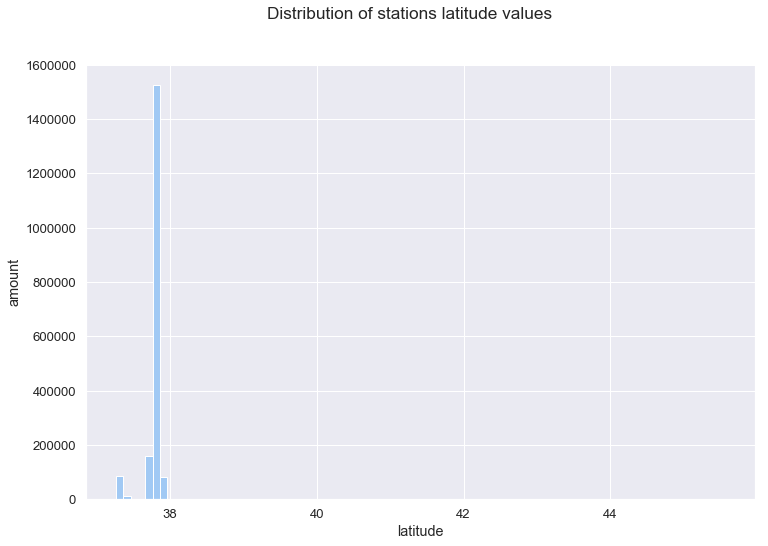

In [22]:
bins = np.arange(df['end_station_latitude'].min(), df['end_station_latitude'].max()+0.1, 0.1)
axes = df['end_station_latitude'].hist(bins=bins)
pl.suptitle("Distribution of stations latitude values");
pl.ylabel("amount");
pl.xlabel("latitude");

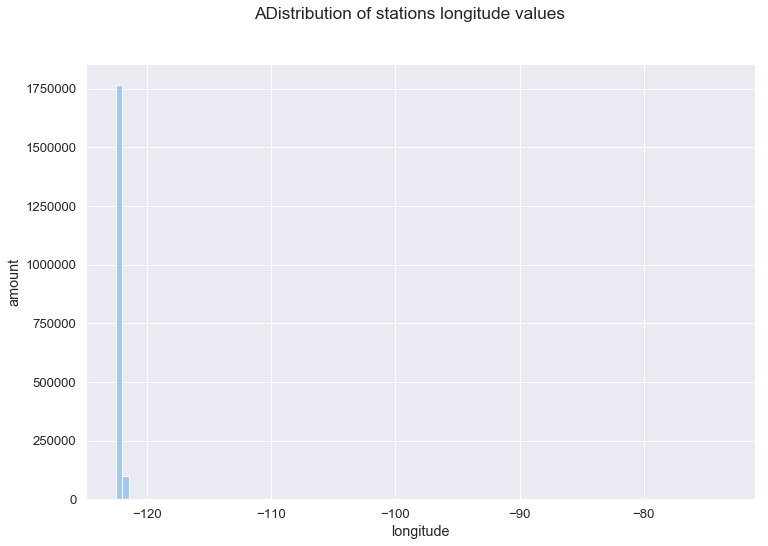

In [23]:
bins = np.arange(df['end_station_longitude'].min(), df['end_station_longitude'].max()+0.5, 0.5)
axes = df['end_station_longitude'].hist(bins=bins)
pl.suptitle("Distribution of stations longitude values");
pl.ylabel("amount");
pl.xlabel("longitude");

There are 11771 missings in columns `end_station_id`, `end_station_name`, `start_station_id` and `start_station_name`. But the latitude and longitude of the start and end stations are available in those rows.

When looking into this latitude and longitude values of the 11771 rows where the station names and ids are missing, then we see, that those values are in a valid range.

When we look at the values of the longitude and latitude of the rows with missing station id and name and the plots of the distribution of longitude and latitude of all stations, we can see that the values are in an expecting range.

So we can assume, that the station id and name is already contained in the data. And this is the reason, why we can fill the missings with reasonable values, with the following approaches.




###### First Approach:
- Extract station id and name from stations with the same longitude and latitude values but with existing station id and name.

--> This didn't worked, because there is no station with the exact same longitude and latitude values as in the missing rows.


###### Second Approach (implemented in the Analysis further below):
- Compute the euclidean distance to every latitude and longitude of existing stations (with valid id and name) and set the missing station id and name to the closest station's name and id.


### 2.3 Values and distribution of variables

Exploring the values of the variables.

In [24]:
df['bike_share_for_all_trip'].value_counts()

No     1701386
Yes     162335
Name: bike_share_for_all_trip, dtype: int64

In [25]:
df['bike_id'].duplicated().any()

True

In [26]:
df['member_gender'].value_counts()

Male      1288085
Female     438188
Other       27081
Name: member_gender, dtype: int64

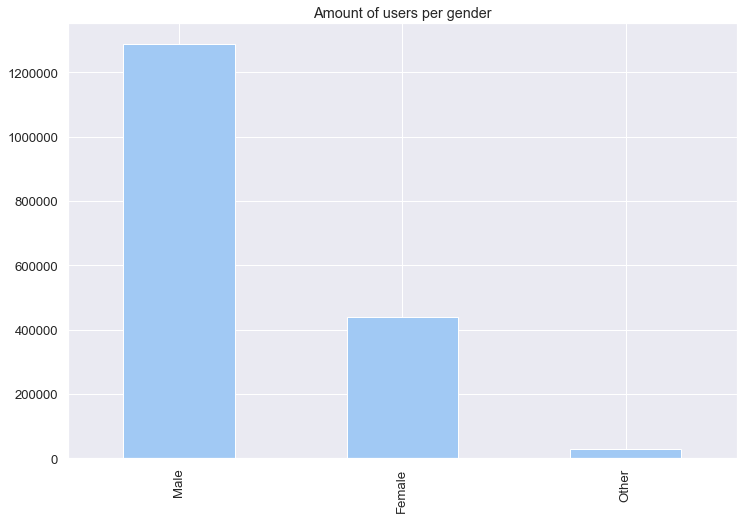

In [27]:
df['member_gender'].value_counts().plot(kind='bar', title='Amount of users per gender');

Only 1/3 of the users are female. 2/3 are male. And a few are of other gender.

In [28]:
df['user_type'].value_counts()

Subscriber    1583554
Customer       280167
Name: user_type, dtype: int64

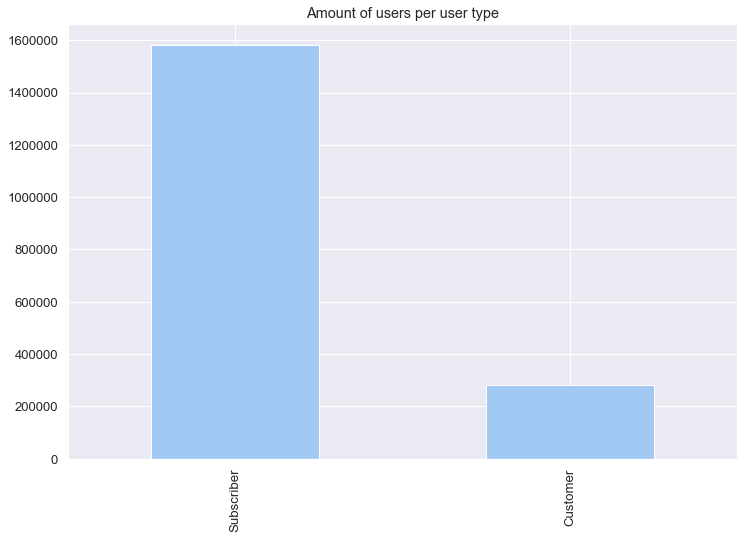

In [29]:
df['user_type'].value_counts().plot(kind='bar', title='Amount of users per user type');

4/5 of the users are subsricber. And 1/5 are customer users.

In [30]:
print("Birth year minimum: ", int(df['member_birth_year'].min()), "\nBirth year maximum: ", int(df['member_birth_year'].max()))

Birth year minimum:  1881 
Birth year maximum:  2000


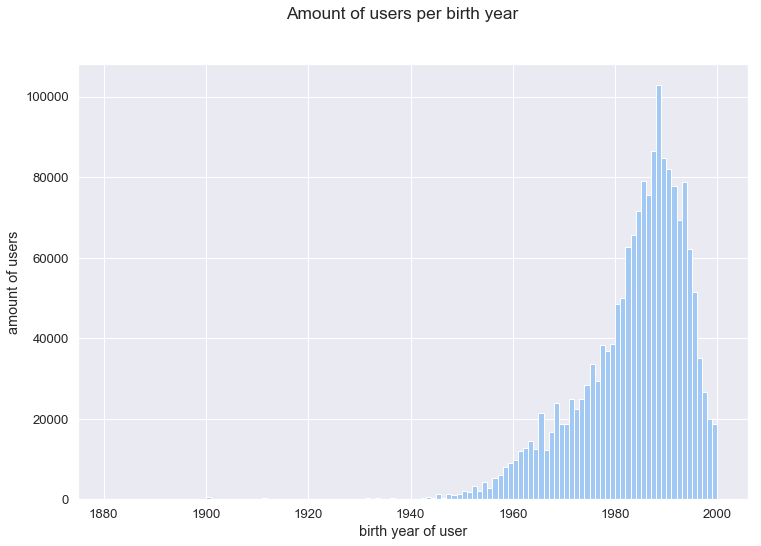

In [31]:
bins = np.arange(df['member_birth_year'].min(), df['member_birth_year'].max()+1, 1)
axes = df['member_birth_year'].hist(bins=bins)
plt.xlabel('birth year of user')
plt.ylabel('amount of users')
pl.suptitle("Amount of users per birth year");

The birth year of the members are inbetween 1881 and 2000. Especially the years between 1881 and about 1940 are questionable, if the bike user was really that old at rent time. This variable has to be cleaned with a reasonable threshold.

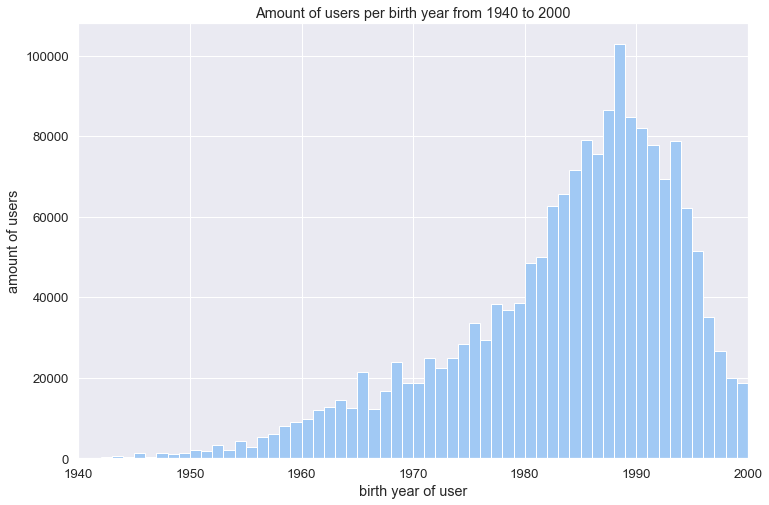

In [32]:
bins = np.arange(df['member_birth_year'].min(), df['member_birth_year'].max()+1, 1)
plt.hist(df['member_birth_year'], bins = bins)
plt.xlabel('birth year of user')
plt.ylabel('amount of users')
plt.xlim(1940, df['member_birth_year'].max()) # could also be called as plt.xlim((0, 35));
plt.title('Amount of users per birth year from 1940 to 2000');

This distribution of the birth year of users seems more reasonable. It is a left skewed distribution.

In [33]:
print("Minimum of start timestamp: ", pd.to_datetime(df['start_time']).min())
print("Minimum of end timestamp: ", pd.to_datetime(df['end_time']).min())

print("Maximum of start timestamp: ", pd.to_datetime(df['start_time']).max())
print("Maximum of end timestamp: ", pd.to_datetime(df['end_time']).max())

Minimum of start timestamp:  2018-01-01 00:01:53.847000
Minimum of end timestamp:  2018-01-01 00:10:06.241000
Maximum of start timestamp:  2018-12-31 23:59:12.097000
Maximum of end timestamp:  2019-01-01 15:05:21.558000


The maximum end timestamp is already in 2019. But the maximum start timestamp is still in 2018, it is reasonable, that a bike was rent until the next day. And it seems like the data set of 2018 was filtered by start timestamp. Which is not a problem.

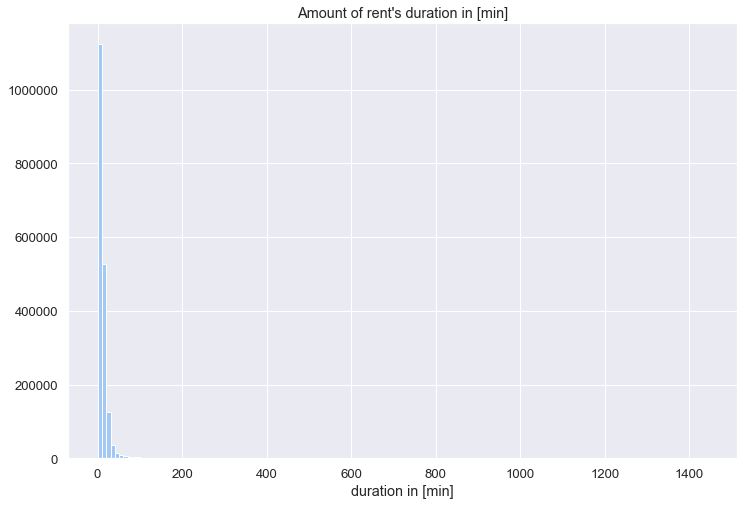

In [34]:
duration_mins = df['duration_sec']/60 # duration time in minutes
edges = np.arange(duration_mins.min(), duration_mins.max()+10, 10)
plt.hist(duration_mins, bins = edges)
plt.xlabel('duration in [min]')
plt.title("Amount of rent's duration in [min]");

In [35]:
duration_mins.max()

1439.4333333333334

The durations of every rent activity lie between 0 and 1439 minutes (after converting to minutes). But the most bikes are only rent for about 0 - 30 minutes, as we can see in the next diagram:

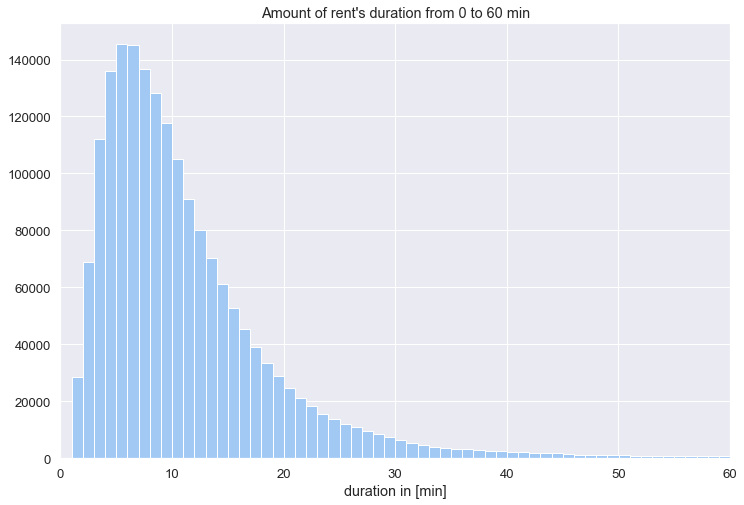

In [36]:
#duration_hours = df['duration_sec']/60/60  # duration time in hours
duration_mins = df['duration_sec']/60 # duration time in minutes
edges = np.arange(duration_mins.min(), duration_mins.max()+1, 1)
plt.hist(duration_mins, bins = edges)
plt.xlabel('duration in [min]')
plt.xlim(0, 60) 
plt.title("Amount of rent's duration from 0 to 60 min");

This is the more interesting range of duration. This distribution is right skewed.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> `duration_sec`: The durations of every rent activity lie between 0 and 1439 minutes (after converting to minutes). But the most bikes are only rent for about 0 - 30 minutes.

> `end_station_latitude`, `end_station_longitude`, `start_station_latitude` and `start_station_longitude`:
See this interpretion of the distribution plot above in the missing section.

> `member_birth_year`: The birth year of the members are inbetween 1881 and 2000. Especially the years between 1881 and about 1940 are questionable, if the bike user was really that old at rent time. This variable has to be cleaned with a reasonable threshold.

> `member_gender`: Only about 1/3 of the users are female. 2/3 are male.

> `user_type`: 4/5 of the users are subscriber. 1/5 are customer.


**Tidyness issues**:

- We can not move the membeer observations (`member_birth_year`, `member_gender` and `user_type`) into another table, because we don't have member id's. This is why we keep the member information as part of the rent observations.

- The observation of the rent activity will keep the member's information (birth year, gender, user type) since it is only available in relation to the rent activity and not referable to individual members.

- But the station information should be in another table (`start_station_id`, `start_station_latitude`, `start_station_longitude`, `start_station_name`, `end_station_id`, `end_station_latitude`, `end_station_longitude`, `end_station_name`). Where start and end is not necessary anymore. Only to reference the station by id for start and end station in the main rent table (`start_station_id` and `end_station_id`).
 

**Quality issues**:

- `bike_share_for_all_trip` is string. It should be of type bool.

- `end_time` and `start_time` are string, must be of data type datetime.

- Same amount of missings in `end_station_id`, `end_station_name`, `start_station_id` and `start_station_name`, also all missings in the same rows. Those can be replaced by obvious values when searching comparable latitude and logitude values of other stations.

-  There are missings in `start_station_id` and `end_station_id`. This is why it both are of type float instead of integer. Must be converted to integer after missings are replaced by obvious values (nearest station's id and name).

-  There are missings in `member_birth_year`. This is why it is a float type instead of integer. Will be kept to not loose NaN values.

- There are outliers in the variable `member_birth_year`.

- About 5.9 % missings in the variables `member_birth_year` and `member_gender`.

## 3. Tidying + Cleaning

### Testing also with data overview or univariate explorations

### Which operations on the data to tidy, adjust, or change the form of the data do you need to perform?


#### Tidying
1. There are three observations: **rent activity** information, **member** informations and **rent stations** information:
    - Due to anonymization the **member information** is not enough to extract each individual member into a member data base. The member information we have in each row is not obviously/distinctly referable to one single member. But we can extract the members information per rent activity in a seperated table and add a rent_id. With this table we can make analysis of members in the view of general users (considering every acitivity is a new user). Due to the fact that we don't have individual member ids, we can not derive an individual member table. This is why, we don't know, for example, if less people use the rent service really often or,the other way around, if there are a lot of users using the service only one time or all inbetween. Copy `member_birth_year`, `member_gender` and `user_type` to that table.
    
    - The **rent activity** table will keep columns: `bike_id`, `bike_share_for_all_trip`, `duration_sec`, `end_station_id`, `end_time`, `start_station_id`, `start_time`.
    
    - The **rent stations** information wil be moved into another table, where station_id, station_latitude, station_longitude and station_name are merged toegehther from both: start_ and end_stations.(`start_station_id`, `start_station_latitude`, `start_station_longitude`, `start_station_name`, `end_station_id`, `end_station_latitude`, `end_station_longitude`, `end_station_name`).


#### Cleaning

2. Convert type of `bike_share_for_all_trip` to data type bool. 

3. Convert types of `end_time` and `start_time` to data type datetime. 

4. Fill missings in variables `start_station_id`, `end_station_id`, `end_station_name` and `start_station_name`. For every row with those missings: 
    
    - Search in the station dataframe for rows, with same or similar (smallest Euclidean distance) `station_latitude`, `station_longitude` data.
    
    - And if there exist such rows: use their `station_id` and `station_name` to fill in the rent dataframe the missings.
    
    - Otherwise: Delete row (station id not known). 

5. Then convert `start_station_id` and `end_station_id`to type integer.

6. There are a lot of outliers in the variable `member_birth_year`. Find a threshold, that is realistic. And delete values (set to NaN) below that threshold. 


### 3.1 Tidying

In [37]:
df_clean = df.copy()

<span style="color:blue">Define:</span>

1. There are three observations: **rent activity** information, **member** informations and **rent stations** information:
    
    - But we can extract the **members information per rent activity** in a seperated table and add a rent_id. 
    
    - The **rent activity** table will keep columns: `bike_id`, `bike_share_for_all_trip`, `duration_sec`, `end_station_id`, `end_time`, `member_birth_year`, `member_gender`, `start_station_id`, `start_time`, `user_type`.
    
    - The **rent stations** information wil be moved into another table, where station_id, station_latitude, station_longitude and station_name are merged toegehther from both: start_ and end_stations.(`start_station_id`, `start_station_latitude`, `start_station_longitude`, `start_station_name`, `end_station_id`, `end_station_latitude`, `end_station_longitude`, `end_station_name`).




<span style="color:purple">Code:</span>

In [38]:
# copy all rows into the appropiate dataframe (member, rent or station)
df_clean['rent_id'] = df_clean.index # unique?
rent_df = df_clean[['rent_id', 'bike_id', 'bike_share_for_all_trip', 'duration_sec', 'start_station_id', 'start_time', 'end_station_id', 'end_time']].copy()
member_df = df_clean[['rent_id', 'member_gender', 'member_birth_year', 'user_type']].copy()
station_temp_df = df_clean[['start_station_id', 'start_station_latitude', 'start_station_longitude', 'start_station_name', 'end_station_id', 'end_station_latitude', 'end_station_longitude', 'end_station_name']].copy()

Extract the station's information to one dataframe independent if it was start or end station.

In [39]:
def extract_station_df(df, start=True):
    """
    The function extracts the information of stations, either start or end stations from a dataframe.
    """
    if start:
        name = 'start'
    else:
        name = 'end'
    new_df['id'] = df[name + '_station_id']
    new_df['latitude'] = df[name + '_station_latitude']
    new_df['longitude'] = df[name + '_station_longitude']
    new_df['name'] = df[name + '_station_name']
    new_df.drop_duplicates(subset=['id', 'latitude', 'longitude', 'name'], inplace=True)


# extract start and end station information separatly into new dataframe    
start_station_df = pd.DataFrame()
end_station_df = pd.DataFrame()
start_station_df = extract_station_df(station_temp_df, start=True)
start_station_df = extract_station_df(station_temp_df, start=False)

# merge start und end stations
station_df = start_station_df.append(end_station_df)

# drop duplicates
station_df.drop_duplicates(subset=['id', 'latitude', 'longitude', 'name'], inplace=True)

# drop if nan in 'id' and 'name', those are filled in later
station_df.dropna(subset=['id', 'name'], inplace=True)

<span style="color:LightSeaGreen">Test:</span>

In [40]:
print('df_clean shape: ', df_clean.shape)
print('rent_df shape: ', rent_df.shape)
print('member_df shape: ', member_df.shape)
print('station_df shape: ', station_df.shape)

df_clean shape:  (1863721, 17)
rent_df shape:  (1863721, 8)
member_df shape:  (1863721, 4)
station_df shape:  (358, 4)


In [41]:
# is rent id in both tables unique?
print(df_clean.index.duplicated().sum())
print(rent_df['rent_id'].duplicated().sum())
print(member_df['rent_id'].duplicated().sum())

0
0
0


The observations were extracted to 3 tables: **rent_df**, **member_df** and **station_df**.

### 3.2. Cleaning

Copying each dataframe for cleaning.

In [42]:
set_style()

In [43]:
# make a copy to clean every dataframe
rent_clean = rent_df.copy()
member_clean = member_df.copy()
station_clean = station_df.copy()

<span style="color:blue">Define:</span>

2. Convert type of `bike_share_for_all_trip` to data type bool. 

<span style="color:purple">Code:</span>

In [44]:
rent_clean['bike_share_for_all_trip'].unique()

array(['No', 'Yes'], dtype=object)

In [45]:
rent_clean['bike_share_for_all_trip'] = rent_clean['bike_share_for_all_trip'].replace({'Yes': True, 'No': False})
rent_clean['bike_share_for_all_trip'] = rent_clean['bike_share_for_all_trip'].astype(bool)

<span style="color:LightSeaGreen">Test:</span>

In [46]:
rent_clean['bike_share_for_all_trip'].unique()

array([False,  True])

In [47]:
rent_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1863721 entries, 0 to 1863720
Data columns (total 8 columns):
rent_id                    int64
bike_id                    int64
bike_share_for_all_trip    bool
duration_sec               int64
start_station_id           float64
start_time                 object
end_station_id             float64
end_time                   object
dtypes: bool(1), float64(2), int64(3), object(2)
memory usage: 101.3+ MB


<span style="color:blue">Define:</span>

3. Convert types of `end_time` and `start_time` to data type datetime. 

<span style="color:purple">Code:</span>

In [48]:
rent_clean['end_time'] = pd.to_datetime(rent_clean['end_time'])
rent_clean['start_time'] = pd.to_datetime(rent_clean['start_time'])

<span style="color:LightSeaGreen">Test:</span>

In [49]:
rent_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1863721 entries, 0 to 1863720
Data columns (total 8 columns):
rent_id                    int64
bike_id                    int64
bike_share_for_all_trip    bool
duration_sec               int64
start_station_id           float64
start_time                 datetime64[ns]
end_station_id             float64
end_time                   datetime64[ns]
dtypes: bool(1), datetime64[ns](2), float64(2), int64(3)
memory usage: 101.3 MB


<span style="color:blue">Define:</span>

4. Fill missings in variables `start_station_id`, `end_station_id`, `end_station_name` and `start_station_name`. For every row with those missings: 
    
    - Search in the station dataframe for rows, with same or similar (smallest Euclidean distance) `station_latitude`, `station_longitude` data.
    
    - And if there exist such rows: use their `station_id` and `station_name` to fill in the rent dataframe the missings.
    
    - Otherwise: Delete row (station id not known). 

<span style="color:purple">Code:</span>

We need to find the closest longitude latitude point (station) for every given longitude, latitude values to find the most realistic sation id and name for the missings in `station_id` and `station_name` of a rent. (euclidean distance computation from: https://stackoverflow.com/questions/41336756/find-the-closest-latitude-and-longitude)

In [50]:
from math import cos, asin, sqrt

def distance(lat1, lon1, lat2, lon2):
    '''
    The distance of 2 points defined by given latitude and longitude coordinates is computed as euclidean distance.
    '''
    p = 0.017453292519943295
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p)*cos(lat2*p) * (1-cos((lon2-lon1)*p)) / 2
    return 12742 * asin(sqrt(a))

def closest_start(data, location):
    """
    The closest station in the station table is computed for a given start location (defined with latitude and longitude) is computed.
    """
    return min(data, key=lambda lookupStation: distance(location['start_station_latitude'],location['start_station_longitude'], lookupStation['latitude'],lookupStation['longitude']))

def closest_end(data, location):
    """
    The closest station in the station table is computed for a given end location (defined with latitude and longitude) is computed.
    """
    return min(data, key=lambda lookupStation: distance(location['end_station_latitude'],location['end_station_longitude'], lookupStation['latitude'],lookupStation['longitude']))

tempDataList = [{'lat': 39.7612992, 'lon': -86.1519681}, 
                {'lat': 39.762241,  'lon': -86.158436 }, 
                {'lat': 39.7622292, 'lon': -86.1578917}]

All 4 station information variables are missing in the same row (see 2. Assessing Data). This is why we now look up the station's name and id from the closest station available in the station dataframe to fill the missings station information in the rent table.

In [51]:
'''
Look up the station's name and id from the closest station available in the station dataframe 
to fill the missings station information in the rent table
'''
where_station_id_name_is_missing = df_clean['start_station_id'].isnull()

# in the df_clean is the only combination of old longitude and latitude in whole dataframe
df_id_missings = df_clean[where_station_id_name_is_missing]
print(df_id_missings.shape[0], " rent activities with missing start and end station id and name.")

# build lookup table with latitude and longitude of all stations as dictionaries
lookupStation = [{'latitude': row['latitude'], 'longitude': row['longitude']} for i, row in station_clean.iterrows()]

# iterate over all rent rows with missing station information, to fill the missings
for i, row in df_id_missings.iterrows():
    # find the closest station (euclidean distance) in the station lookup table
    start_station = closest_start(lookupStation, row)
    end_station = closest_end(lookupStation, row)
    # extract closest station's longitude and latitude 
    start_latitude = start_station['latitude']
    start_longitude = start_station['longitude']
    end_latitude = end_station['latitude']
    end_longitude = end_station['longitude']
    
    # search for the same station with the longitude and latitude information (search in smaller station dataframe)
    start_station_id_frame = station_clean.query('latitude==@start_latitude & longitude==@start_longitude')
    start_station_id = start_station_id_frame['id'].iloc[0]
    #start_station_name = start_station_id_frame['start_station_name'].iloc[0]
    end_station_id_frame = station_clean.query('latitude==@end_latitude & longitude==@end_longitude')
    end_station_id = end_station_id_frame['id'].iloc[0]
    
    # write the found station id and name to replace missings in the rent_clean dataframe
    rent_clean.loc[i, 'start_station_id'] = start_station_id
    rent_clean.loc[i, 'end_station_id'] = end_station_id    

11771  rent activities with missing start and end station id and name.


<span style="color:LightSeaGreen">Test:</span>

In [52]:
print('BEFORE')
print("Missing in rent_df start: ", rent_df['start_station_id'].isnull().sum())
print("Missing in rent_df start: ", rent_df['end_station_id'].isnull().sum())

print('AFTER')
print("Missing in rent_clean start: ", rent_clean['start_station_id'].isnull().sum())
print("Missing in rent_clean start: ", rent_clean['end_station_id'].isnull().sum())

BEFORE
Missing in rent_df start:  11771
Missing in rent_df start:  11771
AFTER
Missing in rent_clean start:  0
Missing in rent_clean start:  0


<span style="color:blue">Define:</span>

5. Then convert `start_station_id` and `end_station_id`to type integer.

<span style="color:purple">Code:</span>



In [53]:
type(rent_clean['start_station_id'][0])

numpy.float64

In [54]:
rent_clean['start_station_id'] = rent_clean['start_station_id'].astype(int)
rent_clean['end_station_id'] = rent_clean['end_station_id'].astype(int)

<span style="color:LightSeaGreen">Test:</span>

In [55]:
type(rent_clean['start_station_id'][0])

numpy.int64

<span style="color:blue">Define:</span>

6. There are a lot of outliers in the variable `member_birth_year`. Find a threshold, that is realistic. And delete values (set to NaN) below that threshold. 

<span style="color:purple">Code:</span>

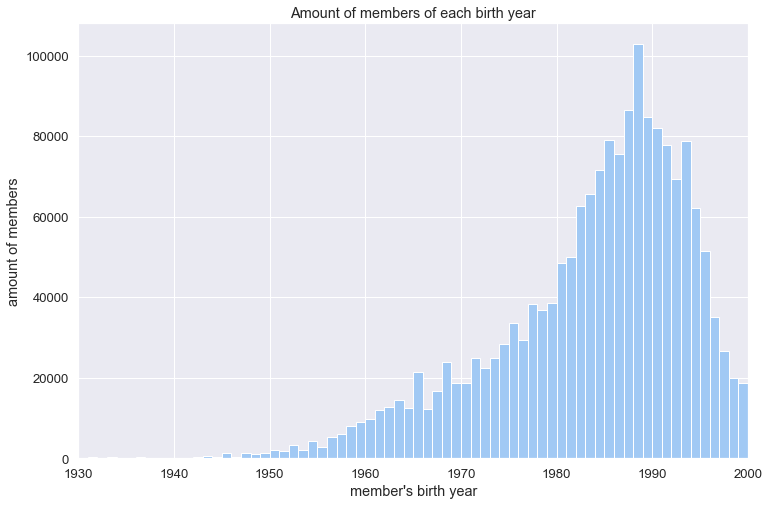

In [56]:
bins = np.arange(member_clean['member_birth_year'].min(), member_clean['member_birth_year'].max()+1, 1)
plt.hist(member_clean['member_birth_year'], bins = bins)
plt.xlabel("member's birth year")
plt.xlim(1930, member_clean['member_birth_year'].max()) 
plt.ylabel('amount of members')
plt.title('Amount of members of each birth year');

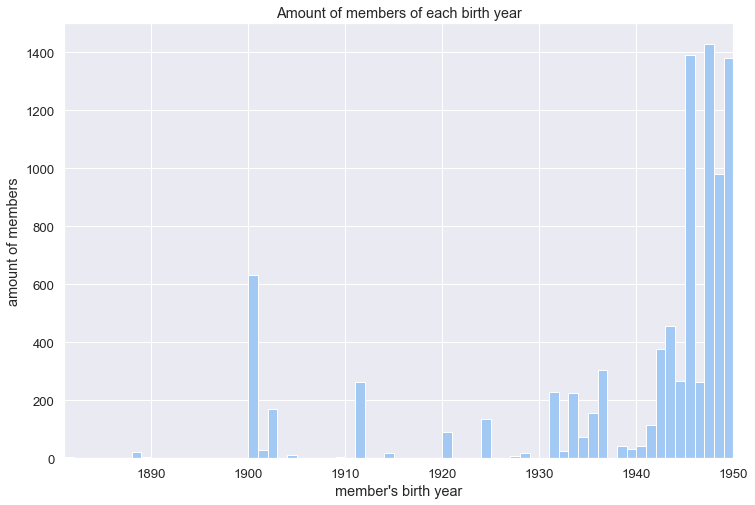

In [57]:
bins = np.arange(member_clean['member_birth_year'].min(), member_clean['member_birth_year'].max()+1, 1)
plt.hist(member_clean['member_birth_year'], bins = bins)
plt.xlabel("member's birth year")
plt.xlim(member_clean['member_birth_year'].min(), 1950)
plt.ylabel('amount of members')
plt.ylim(0, 1500)
plt.title('Amount of members of each birth year');

In [58]:
int(member_clean['member_birth_year'].min()), int(member_clean['member_birth_year'].max())

(1881, 2000)


**What about the peak in 1900?**

- There are multiple (almost 1000) users that set their birth years to 1900.


**If this birth years were true, how old would those user be now?**

- The oldest user would be 137.  


**Are those outliers realistic?**

- The peak of birth year in the 1900 is not that realistic. It is more probable that this comes from an initial birth year set by the system or may also from user fabricating an uncreative fake birth year.

- An age of 137 is really sporty and also using a shared bike service in that age, really honorable! But not really realistic-I would guess.

**Problem:**

- But what would be a realistic age that is trustable? Where do we set a threshold, which data do we want to trust, and which we don't?

**Assumption**

- While looking at the distribution of the outliers of birth years, we assume the threshold 1930 (with a maximum age of 88) is realistic. 

In [59]:
# set birth year to NaN if it is not a realistic birth year
where_birth_year_smaller_1930 = member_clean['member_birth_year'] < 1930
member_clean.loc[where_birth_year_smaller_1930, 'member_birth_year'] = np.NaN

<span style="color:LightSeaGreen">Test:</span>

In [60]:
member_clean['member_birth_year'].min()

1930.0

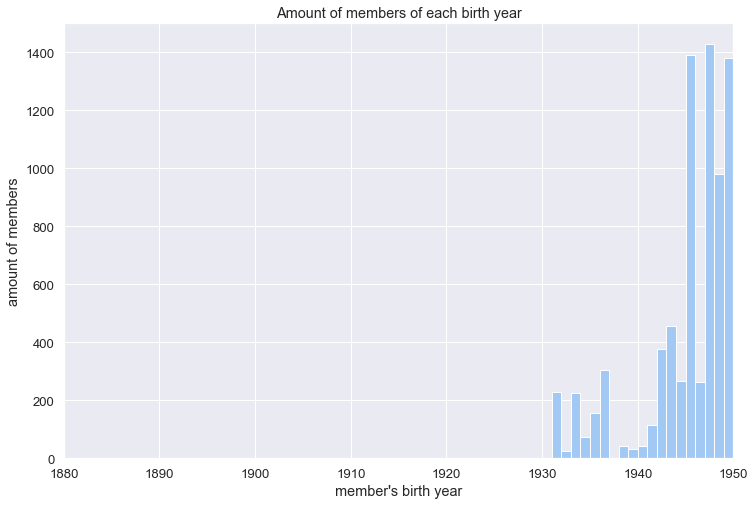

In [61]:
bins = np.arange(member_clean['member_birth_year'].min(), member_clean['member_birth_year'].max()+1, 1)
plt.hist(member_clean['member_birth_year'], bins = bins)
plt.xlabel("member's birth year")
plt.xlim(1880, 1950)
plt.ylabel('amount of members')
plt.ylim(0, 1500)
plt.title('Amount of members of each birth year');

### 3.3 Feature Development

The feature development part is usually developed in the exploration and alalysis step. But a few features are defined here already, to prepare the data in advance. Some other features are added later in the exploration and visualization step.

<span style="color:blue">Define:</span>

We can extract informations of the given variables to generate new features:

- year of renting in rent table

- month of renting in rent table

- daytime (in hour) of renting in rent table

- age of the member in member table



<span style="color:purple">Code:</span>

In [62]:
print(rent_clean.shape[0])
print(member_clean.shape[0])

1863721
1863721


In [63]:
rent_clean['year'] = rent_clean['start_time'].dt.year
rent_clean['month'] = rent_clean['start_time'].dt.month
rent_clean['hour'] = rent_clean['start_time'].dt.hour

In [64]:
# approximate age at rent time, since only year of birth is known, not month
# therefore rent time is needed
member_clean['age'] = rent_clean['year'] - member_clean['member_birth_year']

<span style="color:LightSeaGreen">Test:</span>

In [65]:
rent_clean['year'].value_counts()

2018    1863721
Name: year, dtype: int64

### 3.4 Store cleaned and tidied data

In [66]:
rent_clean.to_csv('data/cleaned/rent.csv', index=False)
member_clean.to_csv('data/cleaned/member.csv', index=False)
station_clean.to_csv('data/cleaned/station.csv', index=False)

In [67]:
conn = sqlite3.connect("data/cleaned/rent.db")
rent_clean.to_sql("rent", conn, if_exists="replace", index=False)

conn = sqlite3.connect("data/cleaned/member.db")
member_clean.to_sql("member", conn, if_exists="replace", index=False)

conn = sqlite3.connect("data/cleaned/station.db")
station_clean.to_sql("station", conn, if_exists="replace", index=False)

Skipp reading from database, because then all type conversions are lost.

In [68]:
#conn = sqlite3.connect("data/cleaned/rent.db")
#rent_clean = pd.read_sql_query("select * from rent;", conn)
#rent_clean.head()

In [69]:
#conn = sqlite3.connect("data/cleaned/member.db")
#member_clean = pd.read_sql_query("select * from member;", conn)
#member_clean.head()

In [70]:
#conn = sqlite3.connect("data/cleaned/station.db")
#station_clean = pd.read_sql_query("select * from station;", conn)
#station_clean.head()

## 4. Analyze and Visualize

### Univariate Explorations

### 4.0 Exploration of new features `age`

In [71]:
set_style()

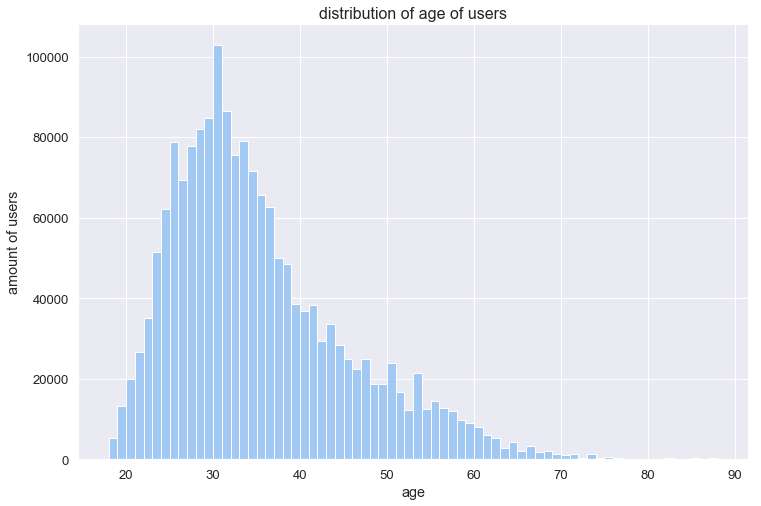

In [72]:
bins = np.arange(member_clean['age'].min(), member_clean['age'].max()+1, 1)
plt.hist(member_clean['age'], bins = bins)
plt.xlabel("age")
#plt.xlim(1880, 1950)
plt.ylabel('amount of users')
#plt.ylim(0, 1500)
plt.title('distribution of age of users', fontsize=16);

In [73]:
member_clean['age'].min(), member_clean['age'].max()

(18.0, 88.0)

The age of the useres is right-skewed distributed. The most users are about 30 years old. The youngest is 18 years old (what may due to a user's contract requirement) and the oldest is 88 years old (after cleaning older members from data).

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> I extracted the new feature `age` out of the member's birth year

> I extracted the new feature `year`, `month` and `hour` out of the feature `start_date`

>   There were some outliers in the variable `member_birth_year`. I decided to clean them with the goal to make the distribution skew normal distributed.

> The station information were extracted to another (smaller) dataframe.

> I filled up the missings in the feature `start_station_id`, `end_station_id`, `start_station_name` and `end_station_name` by inspecting the rows' latitude and longitude and looked for the closest station in the station table.

### Bivariate and Multivariate Explorations

### 4.1 Missings Analysis

In [74]:
rent_clean.isnull().sum()/rent_clean.shape[0]

rent_id                    0.0
bike_id                    0.0
bike_share_for_all_trip    0.0
duration_sec               0.0
start_station_id           0.0
start_time                 0.0
end_station_id             0.0
end_time                   0.0
year                       0.0
month                      0.0
hour                       0.0
dtype: float64

In [75]:
member_clean.isnull().sum()/member_clean.shape[0]

rent_id              0.000000
member_gender        0.059219
member_birth_year    0.060165
user_type            0.000000
age                  0.060165
dtype: float64

In [76]:
station_clean.isnull().sum()/station_clean.shape[0]

id           0.0
latitude     0.0
longitude    0.0
name         0.0
dtype: float64

In [77]:
rent_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1863721 entries, 0 to 1863720
Data columns (total 11 columns):
rent_id                    int64
bike_id                    int64
bike_share_for_all_trip    bool
duration_sec               int64
start_station_id           int64
start_time                 datetime64[ns]
end_station_id             int64
end_time                   datetime64[ns]
year                       int64
month                      int64
hour                       int64
dtypes: bool(1), datetime64[ns](2), int64(8)
memory usage: 144.0 MB


In [78]:
# preparing data for amount of rents over time
amount_of_rent = rent_clean[['start_time']].copy()
amount_of_rent['amount'] = 1
amount_of_rent['date'] = rent_clean['start_time'].dt.date

rent_timeseries = pd.DataFrame(amount_of_rent.groupby('date')['amount'].sum())

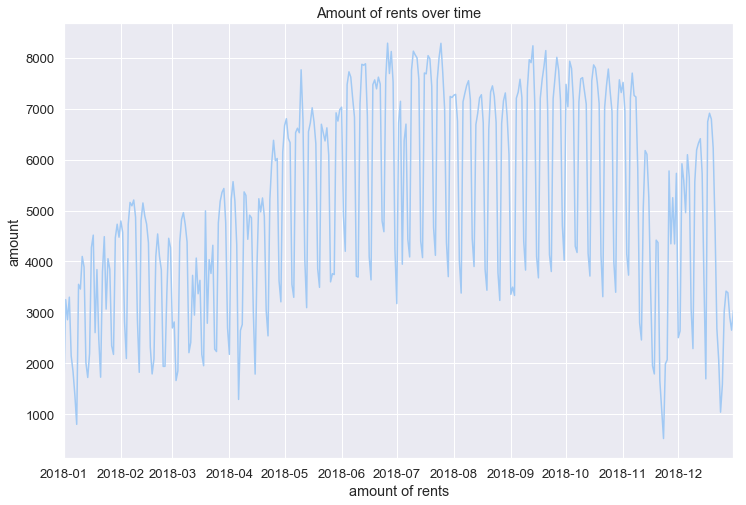

In [79]:
# visualize time series
ax = ax = sns.lineplot(x=rent_timeseries.index, y=rent_timeseries['amount'])
ax.set_xlim(rent_timeseries.index.min(), rent_timeseries.index.max())
ax.set_xlabel("amount of rents")
ax.set_title("Amount of rents over time")

fig = ax.get_figure()

In this diagram you can see the amount of rents per day in 2018. As you can see there were more users in the summer month (May to October), and less rents from November to April. The time serie is not smooth. This is because of daily changes and especially the change between weekdays and weekend days. If we would use a windowing function to average over 7 days, this time series would be more smooth. Also the different between weekdays and weekenddays could be worth a further investigation.

In [80]:
# preparing data for missings of variable over time
member_missings = member_clean.isnull()
member_missings['date'] = rent_clean['start_time'].dt.date

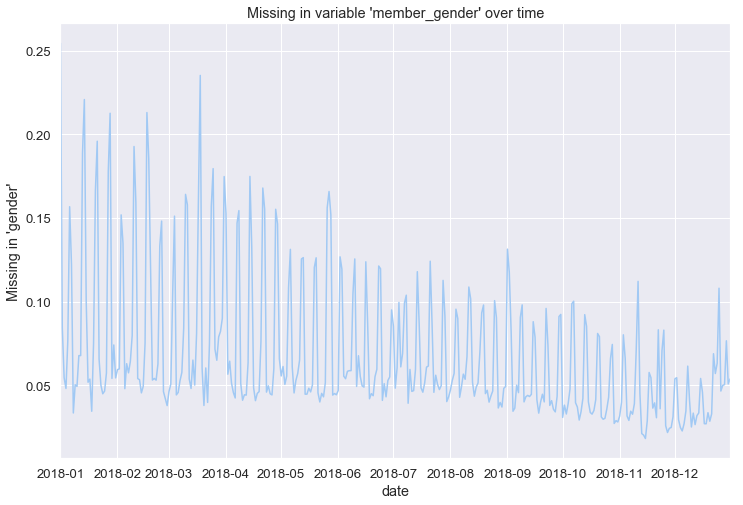

In [81]:
# time series for percental missings in variable: bike_share_for_all_trip
member_timeseries_missing = pd.DataFrame(member_missings.groupby('date')['member_gender'].mean())

# visualize time series
ax = ax = sns.lineplot(x=member_timeseries_missing.index, y=member_timeseries_missing['member_gender'])
ax.set_xlim(member_timeseries_missing.index.min(), member_timeseries_missing.index.max())
ax.set_ylabel("Missing in 'gender'")
ax.set_title("Missing in variable 'member_gender' over time")

fig = ax.get_figure()

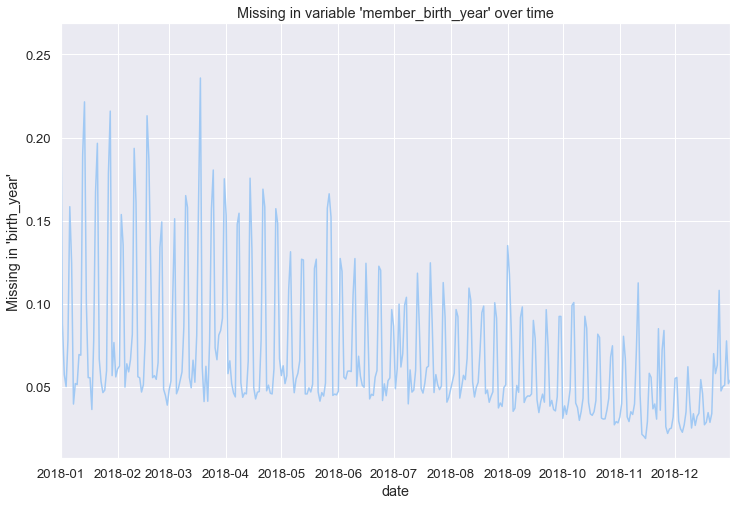

In [82]:
# time series for percental missings in variable: member_birth_year
member_timeseries_missing = pd.DataFrame(member_missings.groupby('date')['member_birth_year'].mean())

# visualize time series
ax = ax = sns.lineplot(x=member_timeseries_missing.index, y=member_timeseries_missing['member_birth_year'])
ax.set_xlim(member_timeseries_missing.index.min(), member_timeseries_missing.index.max())
ax.set_ylabel("Missing in 'birth_year'")
ax.set_title("Missing in variable 'member_birth_year' over time")

fig = ax.get_figure()

As we can see, the missings of member birth and year over time per day (in % of amount of rents per day) became less over the year. One assumption is, that the users that are no subscribers (user type == customer) don't need to save their birth year and gender. This could be investigated further.

In [158]:
'''
Split the member data by its user type. To make visualizations with relative missing amount
related to its type. And make it comparable in a plot.
'''
# make filters to split user types
where_type_is_subscriber = member_clean['user_type'] == 'Subscriber'
where_type_is_customer = member_clean['user_type'] == 'Customer'

# compute relative values of missing variables, relative to amount of its user types
member_missings_subscriber = member_missings[where_type_is_subscriber].copy()
member_missings_customer = member_missings[where_type_is_customer].copy()
member_missings_subscriber['member_birth_year'] = member_missings_subscriber['member_birth_year'] / (member_missings_subscriber.shape[0])
member_missings_customer['member_birth_year'] = member_missings_customer['member_birth_year'] / (member_missings_customer.shape[0])
member_missings_subscriber['member_gender'] = member_missings_subscriber['member_gender'] / member_missings_subscriber.shape[0]
member_missings_customer['member_gender'] = member_missings_customer['member_gender'] / member_missings_customer.shape[0]

# initialize only rents of user type dataframes
#user_type_subscriber_ts = pd.DataFrame(member_missings_subscriber[where_type_is_subscriber].groupby('date')['member_birth_year'].mean())
#user_type_customer_ts = pd.DataFrame(member_missings_customer[where_type_is_customer].groupby('date')['member_birth_year'].mean())

# add columns (computed per user type) back to member_missing df
#member_missings_customer['member_birth_year_type'] = member_missings_subscriber['member_birth_year']
#member_missings_customer['member_gender_type'] = member_missings_subscriber['member_gender']
#member_missings_customer['member_birth_type'] = member_missings_customer['member_birth_year']
#member_missings_customer['member_gender_type'] = member_missings_customer['member_gender']
combined_missings = member_missings_subscriber.append(member_missings_customer, ignore_index=False)
combined_missings['user_type'] = member_clean['user_type']

In [159]:
member_missings_customer['user_type'].unique()

array([False])

In [160]:
member_missings.shape[0]

1863721

(730, 2)


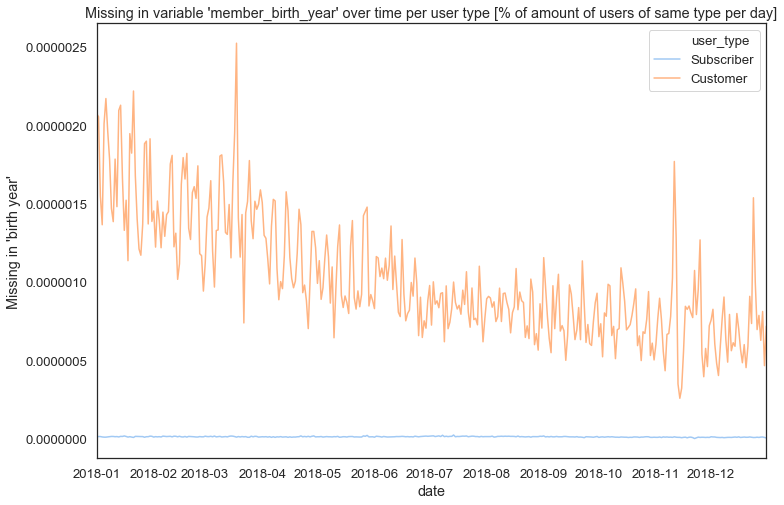

In [170]:
# prepare each time series for both user type separatly to add type as feature
user_type_ts_subscriber = pd.DataFrame(combined_missings.loc[where_type_is_subscriber,:].groupby('date')['member_birth_year'].mean())
user_type_ts_subscriber['user_type'] = 'Subscriber'
user_type_ts_customer = pd.DataFrame(combined_missings.loc[where_type_is_customer,:].groupby('date')['member_birth_year'].mean())
user_type_ts_customer['user_type'] = 'Customer'

# combine both series into one dataframe
user_type_ts = user_type_ts_subscriber.append(user_type_ts_customer, ignore_index=False)
print(user_type_ts.shape)

# visualize time series
ax = ax = sns.lineplot(x=user_type_ts.index, y=user_type_ts['member_birth_year'], hue=user_type_ts['user_type']);
#ax2 = ax2 = sns.lineplot(x=user_type_customer_ts.index, y=user_type_customer_ts['member_birth_year'])

ax.set_xlim(user_type_ts.index.min(), user_type_ts.index.max());
ax.set_ylabel("Missing in 'birth year'");
ax.set_title("Missing in variable 'member_birth_year' over time per user type [% of amount of users of same type per day]")

fig = ax.get_figure();

(730, 2)


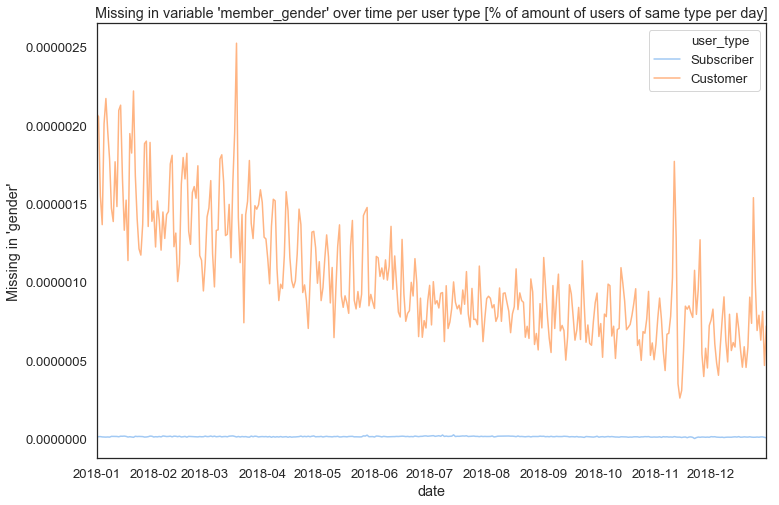

In [172]:
user_type_ts_subscriber = pd.DataFrame(combined_missings.loc[where_type_is_subscriber, :].groupby('date')['member_gender'].mean())
user_type_ts_subscriber['user_type'] = 'Subscriber'
user_type_ts_customer = pd.DataFrame(combined_missings.loc[where_type_is_customer, :].groupby('date')['member_gender'].mean())
user_type_ts_customer['user_type'] = 'Customer'

user_type_ts = user_type_ts_subscriber.append(user_type_ts_customer, ignore_index=False)
print(user_type_ts.shape)

# visualize time series
ax = ax = sns.lineplot(x=user_type_ts.index, y=user_type_ts['member_gender'], hue=user_type_ts['user_type'])
#ax2 = ax2 = sns.lineplot(x=user_type_customer_ts.index, y=user_type_customer_ts['member_birth_year'])
ax.set_ylabel("Missing in 'gender'")

ax.set_xlim(user_type_ts.index.min(), user_type_ts.index.max())
ax.set_title("Missing in variable 'member_gender' over time per user type [% of amount of users of same type per day]")

fig = ax.get_figure()

In above two diagrams you can see the percental amount of missings in the variable birth year and gender seperated by user type. It is computed percential of the amount of rents per day of each user type. As you can see there are much more missing birth years and gender in customer user rents than in subscriber rents. But there are still missings in the subsriber rents. So it is not a must-have variable for 

### 4.2 Rush hours

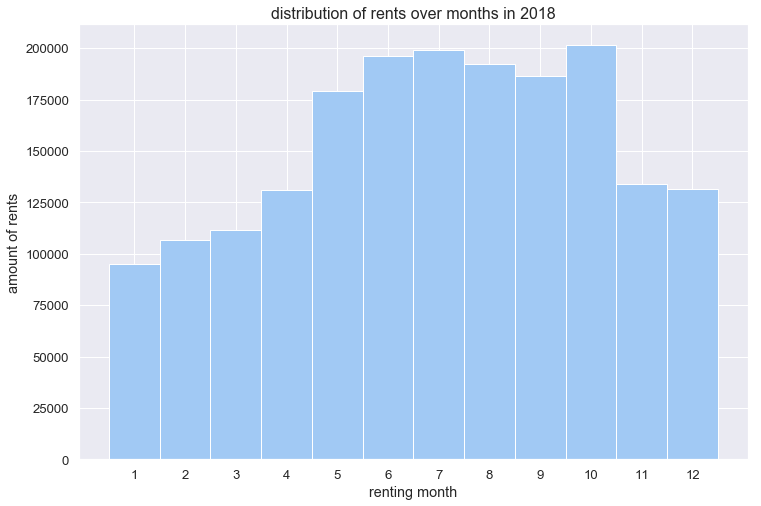

In [88]:
bins = np.arange(rent_clean['month'].min()-0.5, rent_clean['month'].max()+1.1-0.5, 1)
plt.hist(rent_clean['month'], bins = bins)
plt.xlabel("renting month")
plt.xticks(np.arange(rent_clean['month'].min(), rent_clean['month'].max()+1, 1))
plt.ylabel('amount of rents')
#plt.ylim(0, 1500)
plt.title('distribution of rents over months in 2018', fontsize=16);

There are much more rents in the month from May to October. The most rents are in October. And there are notieable less in November compared to the month before. Maybe this depends on a weather change in this month. Therefore addtional data like weather data could be analyzed in a further research. A bias what is also not considered, is the average member amount in each month. Maybe the bike rent service got more popular over this year. Then there would been more rents at the end of the year (December) than in the beginning (January). But this data is not available, since we dan't have member ids. We can not distinguish between member amount and seasonal usage amount.

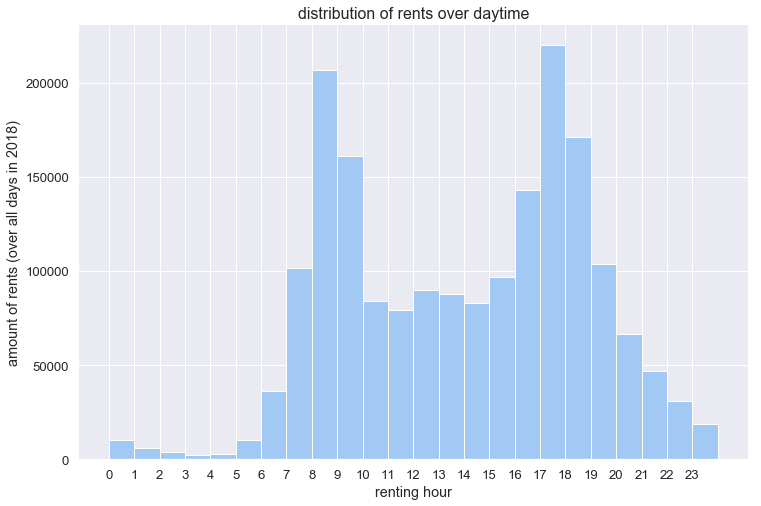

In [89]:
bins = np.arange(rent_clean['hour'].min(), rent_clean['hour'].max()+1.1, 1)
plt.hist(rent_clean['hour'], bins = bins)
plt.xlabel("renting hour")
plt.xticks(np.arange(0, rent_clean['hour'].max()+1, 1))
plt.ylabel('amount of rents (over all days in 2018)')
#plt.ylim(0, 1500)
plt.title('distribution of rents over daytime', fontsize=16);

In this plot we can see, that there are a different amount of rents in every hour (accumulated over all day in year 2018). The rush hours between 7-10 o'clock and 15-19 o'clock are up to twice as busy as the daytime between 10 and 15 o'clock. Whereas the nighttime between 22 and 6 o'clock is noticeable less busy. 

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> The amount of rents per day varies daily. But over all we can see, that there are more rents from May until November. A seasonable trend.

> The missings in the variable member gender and birth year were higher (about 10%) in the first half of the year. They became fewer in the end of the year (5%).

> The insights confirmed that there are more bike rents at rush hours but also in summer months.

> An additionally insight is, that bikes are rented for mostly about 5-15 minuts.


### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> There are much more missings in the variables gender and birth year in the customer user's data than in the subscriber's user data.

In [90]:
# new feature 'amount' into station_clean
amount_of_rent = rent_clean[['start_time']].copy()
amount_of_rent['amount'] = 1
amount_of_rent['hour'] = rent_clean['start_time'].dt.hour
amount_of_rent['month'] = rent_clean['start_time'].dt.month

#print(hourly_amount['amount'].min(), hourly_amount['amount'].max())

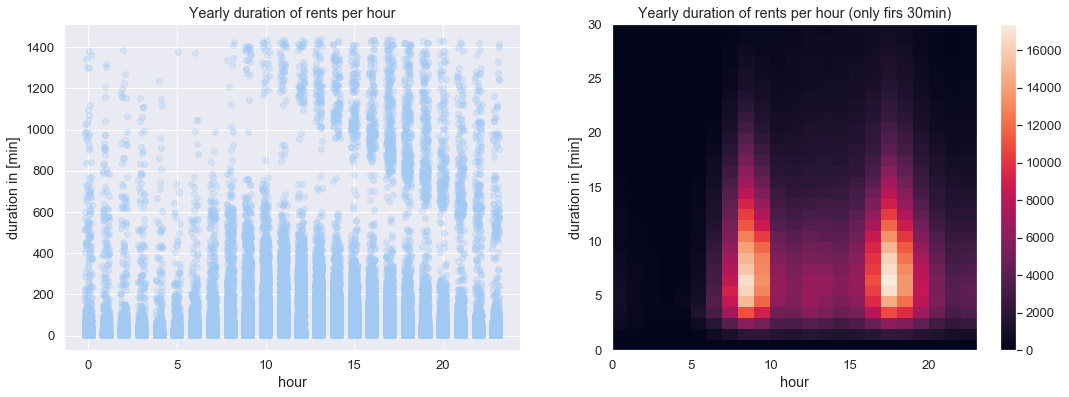

In [91]:
plt.figure(figsize = [18, 6])

# left plot: scatterplot of discrete data with jitter and transparency
ax1 = plt.subplot(1, 2, 1)

sns.regplot( x = rent_clean['hour'], y = rent_clean['duration_sec']/60, fit_reg = False,
            x_jitter = 0.2, scatter_kws = {'alpha' : 0.3})
ax1.set_title("Yearly duration of rents per hour")
ax1.set_ylabel("duration in [min]")

# right plot: heat map with bin edges between values
ax2 = plt.subplot(1, 2, 2)
bins_y = np.arange(0, 31, 1)
bins_x = np.arange(0, 24, 1)
plt.hist2d(x = rent_clean['hour'], y = rent_clean['duration_sec']/60,
           bins = [bins_x, bins_y]);

ax2.set_title("Yearly duration of rents per hour (only firs 30min)")
ax2.set_xlabel("hour")
ax2.set_ylabel("duration in [min]")
plt.colorbar();

In this multivariate visualization we can see a lot about the busiest hours in 2018 and about the most used duration time of the bikes. 

In the left plot we can see not as much as in the right plot due to the fact, that multiple rent acitivites are ploted on top of each other. But we can see, that the later the hour the shorter is the duration time. But also there are a gap between short duration times (0 to about 200min) and really long duration times (from about 10hours to 24hours). This would be interesting for a further research. Maybe this is caused by a systematical behaviour or system error when bikes are not registered or sign off correctly. This will not be investigated here.

The left plot zooms in to the more interesting duration time from 0-30min. Because we saw in the distribution of the duration times, that the most bikes were rent for under 30 minutes. Here a heatmap is used, to plot the amount of rents per hour (x-axis) and per used duration time (y-axis). As we can see here, the bikes are mostly rented in the rush-hours between 7-10h in the morning and 16-20h in the evening. Beside that fact, the heatmap shows, that the bikes are mostly rented for about 3-15 minutes.

### 4.3 Business and Location of the rent stations

Where are those rent stations located? And how busy are those rent stations? Where are the busiest rent stations?

Preparing: Feature development

- add new feature 'amount' to station dataframe (the amount of rents in that station in year 2018).

In [92]:
# preparing rush on stations
# therefor add ammount 1 for every rent activity in rent dataframe
rush_df = rent_clean.copy()
rush_df['amount'] = 1

# then make new dataframe where rows are grouped by its station ids (for start and end)
station_rush_start = pd.DataFrame(rush_df.groupby('start_station_id')['amount'].sum())
station_rush_end = pd.DataFrame(rush_df.groupby('end_station_id')['amount'].sum())
print('amount start stations: ', station_rush_start.shape[0])
print('amount end stations: ', station_rush_end.shape[0])

# rename the station id column in the end station dataframe,
# so that it has same columns as start station dataframe
station_rush_end.index.names = ['start_station_id']

# write combined dataframes with station id and aggregated amount per station to rush df
rush = station_rush_start # .append(pd.DataFrame(station_rush_end))

print('BEFORE merging start and end ids: ', rush.shape)

for i, row in pd.DataFrame(station_rush_end).iterrows():
    if i in list(rush.index):
        rush.loc[i, 'amount'] += row['amount']
    else:
        rush = rush.append(row)
        
print('AFTER merging start and end ids: ', rush.shape)

amount start stations:  331
amount end stations:  331
BEFORE merging start and end ids:  (331, 1)
AFTER merging start and end ids:  (331, 1)


Before and after merging start and end stations, there are still 331 stations. This means, all stations are used as start and end stations.

In [93]:
rush.head()

,amount
start_station_id,
3,64742
4,12099
5,51009
6,72612
7,17224


In [94]:
# copy the amount of stations (in rush df) to a full station data frame
rush_stations = station_clean.copy()
rush_stations['amount'] = 0

# iterate over data frame with all station information to add the amount per station
# (iteration needed due to different indexes in both dataframes)
for i, row in rush_stations.iterrows():
    station_id = row['id']
    if station_id in list(rush.index.values):
        amount = rush['amount'][station_id]
        rush_stations.loc[i, 'amount'] = amount

In [95]:
# converting data type to int
rush_stations['id'] = rush_stations['id'].astype(int)

In [96]:
set_style()

Stations dataframe with new feature `amount`

In [97]:
rush_stations.head()

,id,latitude,longitude,name,amount
0,284,37.784872,-122.400876,Yerba Buena Center for the Arts (Howard St at ...,22990
1,6,37.804770,-122.403234,The Embarcadero at Sansome St,72612
2,93,37.770407,-122.391198,4th St at Mission Bay Blvd S,37363
4,308,37.336802,-121.894090,San Pedro Square,6053
5,312,37.329732,-121.901782,San Jose Diridon Station,11588


Text(0.5, 1.0, 'Rent stations ordered by rent amount/year')

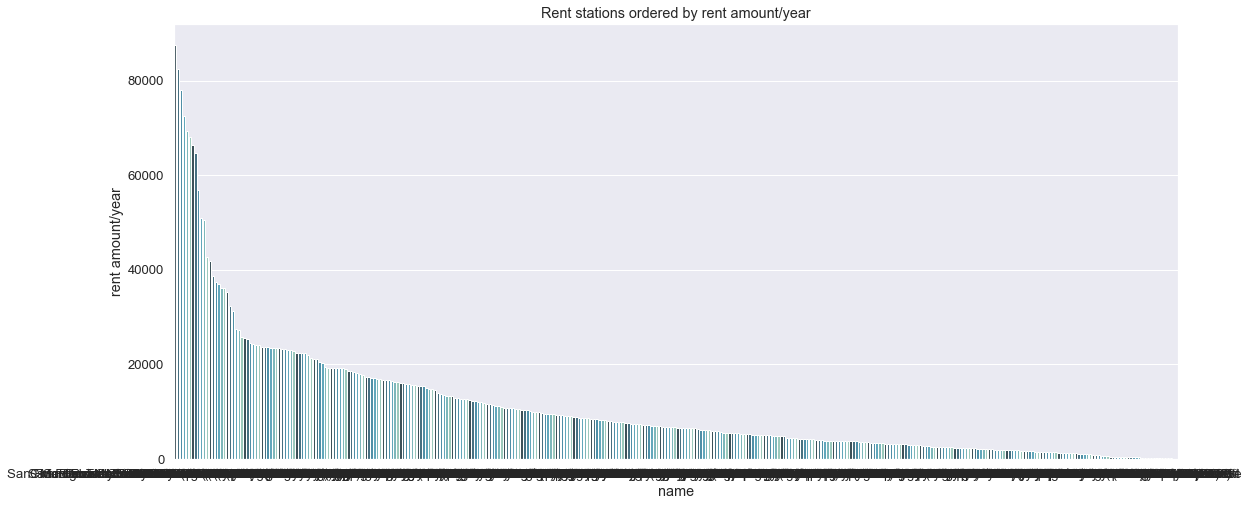

In [98]:
result = rush_stations.groupby(["name"])['amount'].aggregate(np.median).reset_index().sort_values('amount')
fig, ax = fig, ax = plt.subplots()
fig.set_size_inches(18, 8)
ax = sns.barplot(x='name', y="amount", data=rush_stations, order=result['name'].iloc[::-1], palette=sns.color_palette("GnBu_d"))
ax.set_ylabel('rent amount/year')
plt.title('Rent stations ordered by rent amount/year', )
#plt.xticks(rotation=90);

In the above diagram we can see the stations ordered by their amount of rents in year 2018. So the busiest station is on the left. The station with lowest rents on the right. But so far, we can't read the station'name at the x-axis. This is why we need to scale the view to the x-axis. Let's have a look to just the 40 busiest stations.

In [99]:
result.shape

(348, 2)

Text(0.5, 1.0, '40 busiest rent staions (ordered by rent amount/year)')

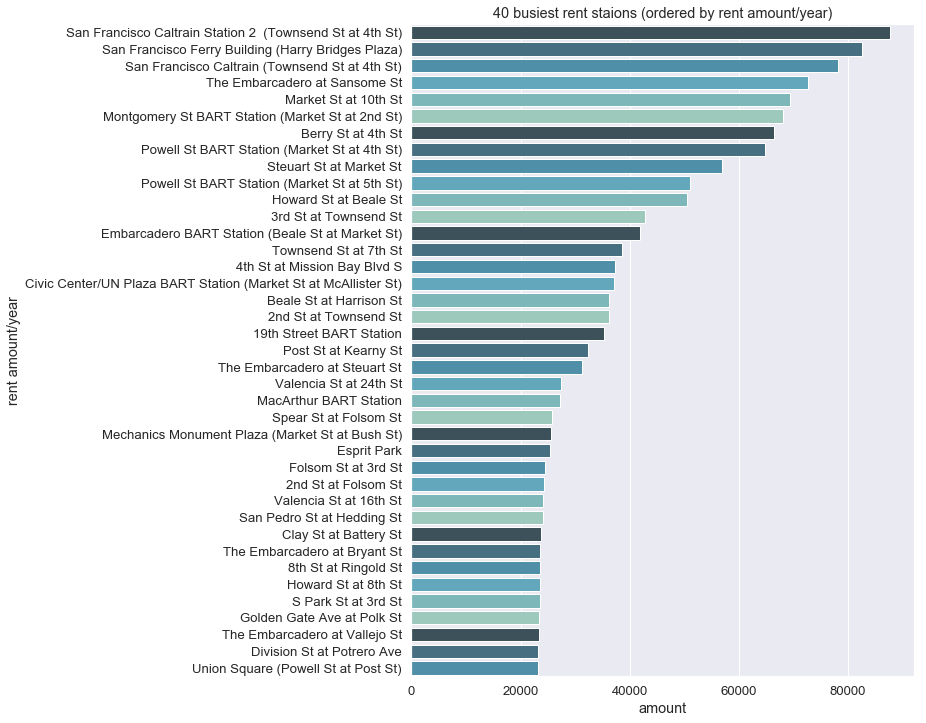

In [178]:
# show only left 40 bussyiest stations
fig, ax = fig, ax = plt.subplots()
fig.set_size_inches(9, 12)
ax = sns.barplot(x='amount', y="name", data=rush_stations, order=result['name'].iloc[:308:-1], palette=sns.color_palette("GnBu_d"))
ax.set_ylabel('rent amount/year')
plt.title('40 busiest rent staions (ordered by rent amount/year)')

In the above visualization, we can see that the station with name `San FranciscoCaltrain Station 2 (Townsened St at 4th St)` is the station with the most rents in year 2018. There are about 10-20 more busier stations with decreasing amount of rents. All other stations are less busy and had more or less the same amount of rents in the year 2018 (about 20000 rents/year).

#### Location of stations (and their amount of rents/year)

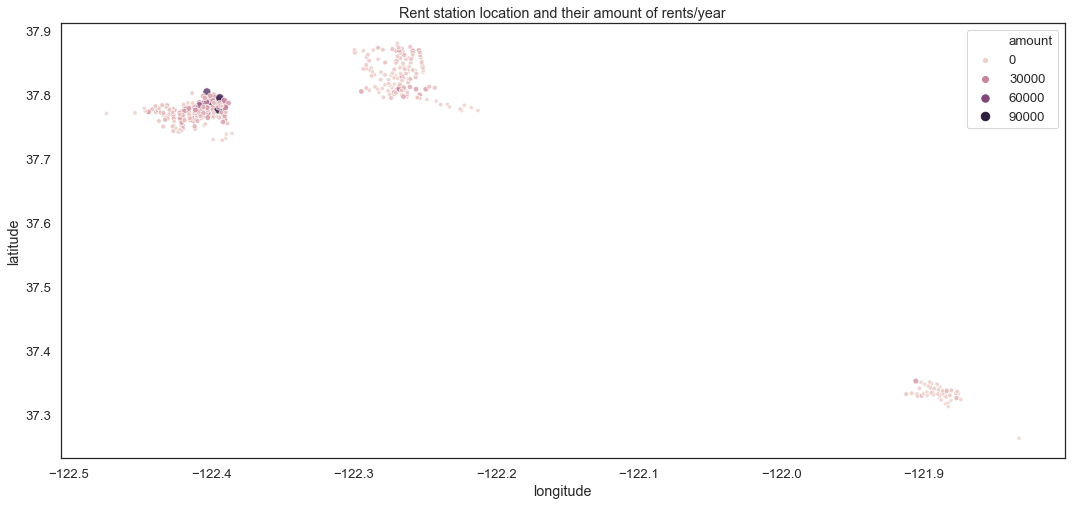

In [101]:
sns.set_style("white")

fig, ax = fig, ax = plt.subplots()
fig.set_size_inches(18, 8)
ax = sns.scatterplot(x="longitude", y="latitude",
                      hue="amount", size="amount",alpha=.8,
                      data=rush_stations);
#ax.set_ylim(rush_stations['latitude'].min(), rush_stations['latitude'].max())
ax.set_title("Rent station location and their amount of rents/year");

In [174]:
set_style()

#### Rent stations in map

See example from: https://jakevdp.github.io/PythonDataScienceHandbook/04.13-geographic-data-with-basemap.html

In [103]:
list(member_clean)

['rent_id', 'member_gender', 'member_birth_year', 'user_type', 'age']

In [104]:
# Extract the data we're interested in
lat = rush_stations['latitude'].values
lon = rush_stations['longitude'].values
amount = rush_stations['amount'].values
#area = cities['area_total_km2'].values


In [175]:
print('latitude range:', rush_stations['latitude'].min(), rush_stations['latitude'].max())
print('longitude range: ',rush_stations['longitude'].min(), rush_stations['longitude'].max())

# compute statistics
mean_latitude = rush_stations['latitude'].mean()
mean_longitude = rush_stations['longitude'].mean()
diff_latitude = rush_stations['latitude'].max() - rush_stations['latitude'].min()
diff_longitude =  rush_stations['longitude'].max() - rush_stations['longitude'].min()

print('latitude and longitude mean:', mean_latitude, mean_longitude)
print('range difference: ', diff_latitude, diff_longitude)

latitude range: 37.26331 37.88022244590679
longitude range:  -122.473658 -121.83333200000001
latitude and longitude mean: 37.73065393097607 -122.27529277694882
range difference:  0.6169124459067916 0.6403259999999875


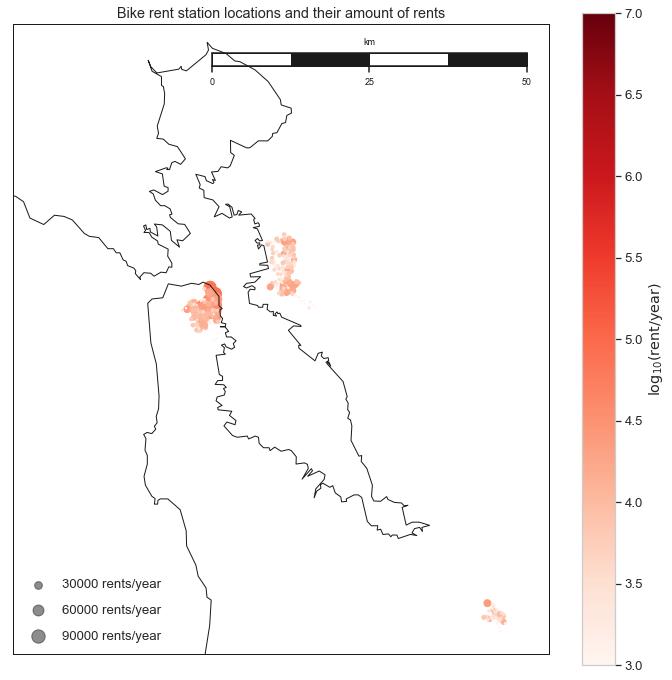

In [106]:
# 1. Draw the map background
fig = plt.figure(figsize=(12, 12))
m = Basemap(projection='tmerc', resolution='h', 
            lat_0=mean_latitude, lon_0=mean_longitude,
            width=0.085E6, height=0.1E6)
#m.shadedrelief()
m.drawcoastlines()
m.drawcountries(color='gray')
#m.fillcontinents(color="#cc9955", lake_color="aqua")
m.drawmapboundary()
#m.drawrivers()
#m.drawstates(color='gray')

m.drawmapscale(lon=mean_longitude+0.16, lat=mean_latitude+0.4, lon0=mean_longitude, lat0=mean_latitude, length=50, barstyle='fancy')

# 2. scatter city data, with color reflecting population
# and size reflecting area
m.scatter(lon, lat, latlon=True,
          c=np.log10(amount), s=amount/500,
          cmap='Reds', alpha=1)
#plt.scatter(lon, lat, 10, marker='o', color='red')

#x, y = m(lon, lat) # transform coordinates
#plt.scatter(x,y,10, marker='o', color='red')


plt.title('Bike rent station locations and their amount of rents');
#plt.show()

# 3. create colorbar and legend
plt.colorbar(label=r'$\log_{10}({\rm rent/year})$')
plt.clim(3, 7)

# make legend 
for a in [30000, 60000, 90000]:
    plt.scatter([], [], c='k', alpha=0.5, s=a/500,
                label=str(a) + ' rents/year')
plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left');

When we plot the station locations into a map, we see that there are three main parts (clusters), where the stations are located. It seems that the rent service has stations in three different cities. Let's try to find out, where the center of those 3 station clusters are. So that we can name them by their city name in an additional feature.

### 4.3 Cluster the 3 regions of rent stations

Use k-means algorithm from:  https://mubaris.com/posts/kmeans-clustering/

In [107]:
%matplotlib inline
from copy import deepcopy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

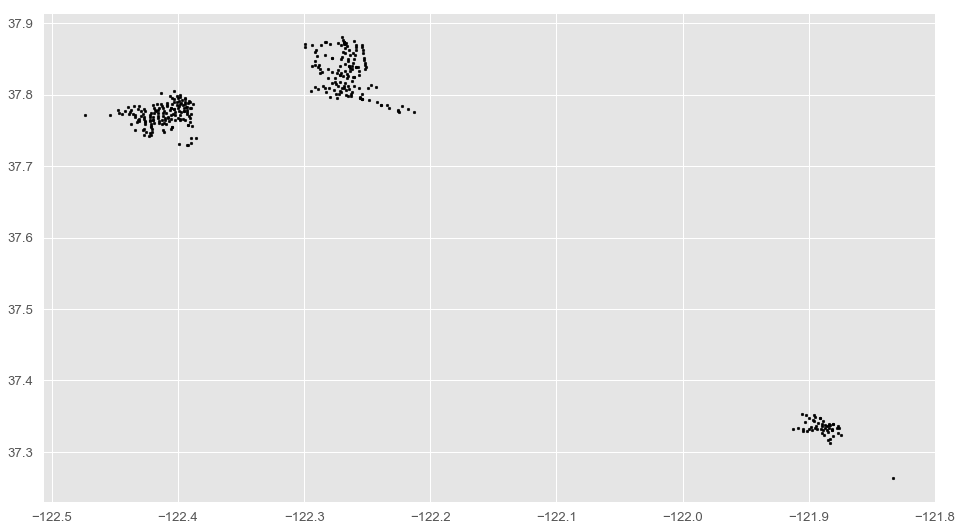

In [108]:
# Getting the values of stations and plotting it
f1 = rush_stations['latitude'].values
f2 = rush_stations['longitude'].values
X = np.array(list(zip(f1, f2)))
plt.scatter(f2, f1, c='black', s=7);

In [109]:
# Euclidean Distance Caculator
def dist(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)

In [110]:
# Number of clusters (set to 3)
k = 3
# X coordinates of random centroids
C_x = np.array([37.4, 37.7, 37.9])
# Y coordinates of random centroids
C_y = np.array([-122.0, -122.4, -122.2])
C = np.array(list(zip(C_x, C_y)), dtype=np.float32)
print(C)

[[  37.4 -122. ]
 [  37.7 -122.4]
 [  37.9 -122.2]]


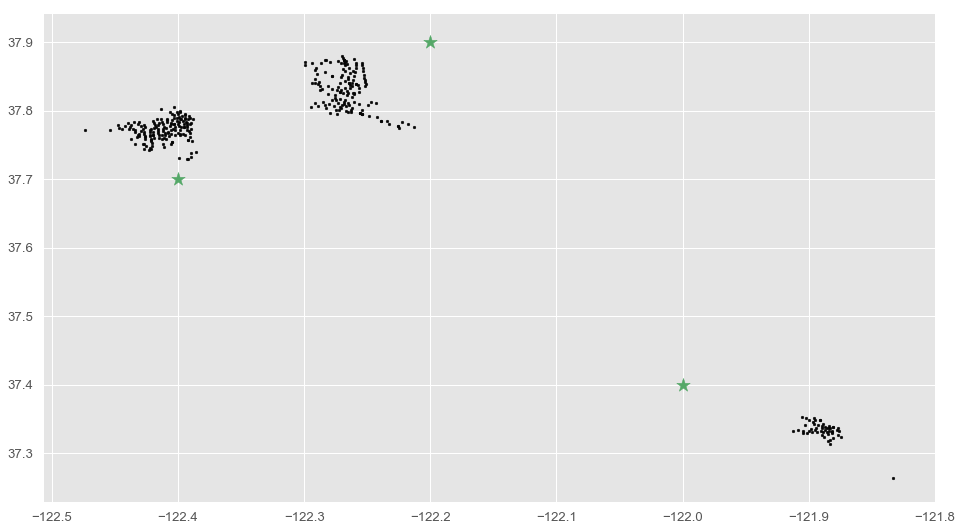

In [111]:
# Plotting along with the initial centroids
plt.scatter(f2, f1, c='#050505', s=7)
plt.scatter(C_y, C_x, marker='*', s=200, c='g')

In [112]:
# To store the value of centroids when it updates
C_old = np.zeros(C.shape)
# Cluster Lables(0, 1, 2)
clusters = np.zeros(len(X))
# Error func. - Distance between new centroids and old centroids
error = dist(C, C_old, None)
# Loop will run till the error becomes zero
while error != 0:
    # Assigning each value to its closest cluster
    for i in range(len(X)):
        distances = dist(X[i], C)
        cluster = np.argmin(distances)
        clusters[i] = cluster
    # Storing the old centroid values
    C_old = deepcopy(C)
    # Finding the new centroids by taking the average value
    for i in range(k):
        points = [X[j] for j in range(len(X)) if clusters[j] == i]
        C[i] = np.mean(points, axis=0)
    error = dist(C, C_old, None)

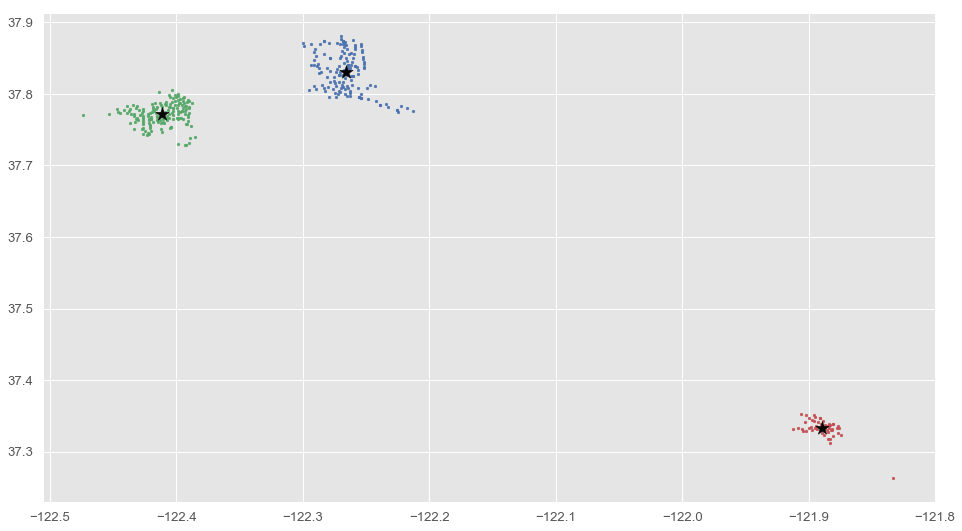

In [113]:
# initalize colors and plot after assignment to cluster of eachstation and new centroids
colors = ['r', 'g', 'b', 'y', 'c', 'm']
fig, ax = plt.subplots()
for i in range(k):
        points = np.array([X[j] for j in range(len(X)) if clusters[j] == i])
        ax.scatter(points[:, 1], points[:, 0], s=7, c=colors[i])
ax.scatter(C[:, 1], C[:, 0], marker='*', s=200, c='#050505');

In [114]:
# centroid (cluser centers)
C

array([[  37.333435, -121.88909 ],
       [  37.771667, -122.411606],
       [  37.830585, -122.26604 ]], dtype=float32)

There were three city centers found: **San_Jose**, **San_Francisco**, **East_Bay**.

#### Bike rent stations in San José

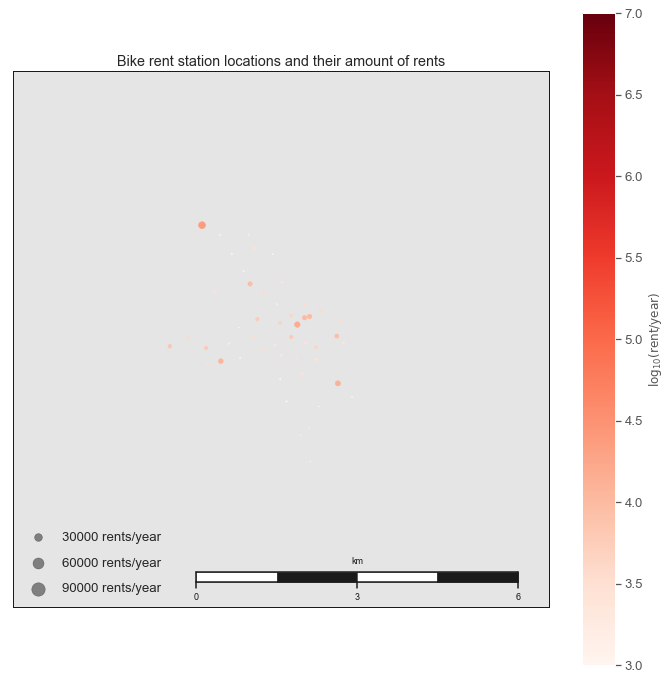

In [115]:
# draw map for first cluster center
center = C[0]

# 1. Draw the map background
fig = plt.figure(figsize=(12, 12))
m = Basemap(projection='tmerc', resolution='h', 
            lat_0=center[0], lon_0=center[1],
            width=0.01E6, height=0.01E6)
#m.shadedrelief()
m.drawcoastlines()
m.drawcountries(color='gray')
#m.fillcontinents(color="#cc9955", lake_color="aqua")
m.drawmapboundary()
#m.drawrivers()
#m.drawstates(color='gray')

m.drawmapscale(lon=center[1]+0.016, lat=center[0]-0.04, 
               lon0=center[1], lat0=center[0], length=6, barstyle='fancy')

# 2. scatter city data, with color reflecting population
# and size reflecting area
m.scatter(lon, lat, latlon=True,
          c=np.log10(amount), s=amount/500,
          cmap='Reds', alpha=1)
#plt.scatter(lon, lat, 10, marker='o', color='red')

#x, y = m(lon, lat) # transform coordinates
#plt.scatter(x,y,10, marker='o', color='red')


plt.title('Bike rent station locations and their amount of rents');
#plt.show()

# 3. create colorbar and legend
plt.colorbar(label=r'$\log_{10}({\rm rent/year})$')
plt.clim(3, 7)

# make legend with dummy points
for a in [30000, 60000, 90000]:
    plt.scatter([], [], c='k', alpha=0.5, s=a/500,
                label=str(a) + ' rents/year')
plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left');

#### Bike rent stations in San Francisco

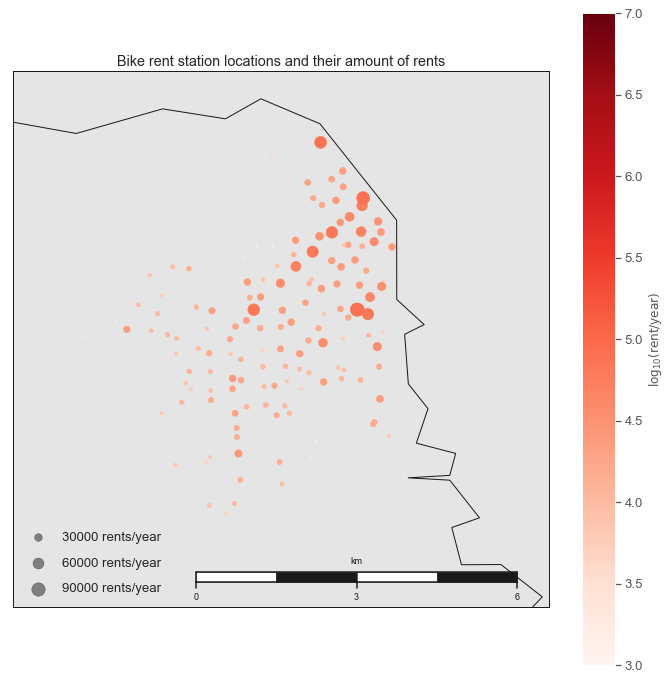

In [116]:
# draw map for first cluster center
center = C[1]

# 1. Draw the map background
fig = plt.figure(figsize=(12, 12))
m = Basemap(projection='tmerc', resolution='h', 
            lat_0=center[0], lon_0=center[1],
            width=0.01E6, height=0.01E6)
#m.shadedrelief()
m.drawcoastlines()
m.drawcountries(color='gray')
#m.fillcontinents(color="#cc9955", lake_color="aqua")
m.drawmapboundary()
#m.drawrivers()
#m.drawstates(color='gray')

m.drawmapscale(lon=center[1]+0.016, lat=center[0]-0.04, 
               lon0=center[1], lat0=center[0], length=6, barstyle='fancy')

# 2. scatter city data, with color reflecting population
# and size reflecting area
m.scatter(lon, lat, latlon=True,
          c=np.log10(amount), s=amount/500,
          cmap='Reds', alpha=1)
#plt.scatter(lon, lat, 10, marker='o', color='red')

#x, y = m(lon, lat) # transform coordinates
#plt.scatter(x,y,10, marker='o', color='red')


plt.title('Bike rent station locations and their amount of rents');
#plt.show()

# 3. create colorbar and legend
plt.colorbar(label=r'$\log_{10}({\rm rent/year})$')
plt.clim(3, 7)

# make legend with dummy points
for a in [30000, 60000, 90000]:
    plt.scatter([], [], c='k', alpha=0.5, s=a/500,
                label=str(a) + ' rents/year')
plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left');

#### Bike rent stations in East Bay

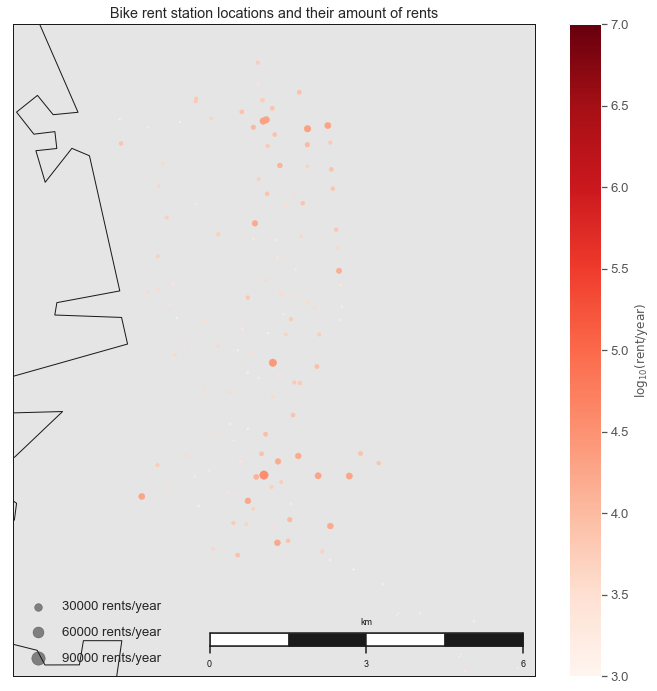

In [117]:
# draw map for first cluster center
center = C[2]

# 1. Draw the map background
fig = plt.figure(figsize=(12, 12))
m = Basemap(projection='tmerc', resolution='h', 
            lat_0=center[0], lon_0=center[1],
            width=0.01E6, height=0.0125E6)
#m.shadedrelief()
m.drawcoastlines()
m.drawcountries(color='gray')
#m.fillcontinents(color="#cc9955", lake_color="aqua")
m.drawmapboundary()
#m.drawrivers()
#m.drawstates(color='gray')

m.drawmapscale(lon=center[1]+0.02, lat=center[0]-0.05, 
               lon0=center[1], lat0=center[0], length=6, barstyle='fancy')

# 2. scatter city data, with color reflecting population
# and size reflecting area
m.scatter(lon, lat, latlon=True,
          c=np.log10(amount), s=amount/500,
          cmap='Reds', alpha=1)
#plt.scatter(lon, lat, 10, marker='o', color='red')

#x, y = m(lon, lat) # transform coordinates
#plt.scatter(x,y,10, marker='o', color='red')


plt.title('Bike rent station locations and their amount of rents');
#plt.show()

# 3. create colorbar and legend
plt.colorbar(label=r'$\log_{10}({\rm rent/year})$')
plt.clim(3, 7)

# make legend with dummy points
for a in [30000, 60000, 90000]:
    plt.scatter([], [], c='k', alpha=0.5, s=a/500,
                label=str(a) + ' rents/year')
plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left');

In the above maps of the 3 cities we can see the distributed locations of the rent stations in each city and their different amount of rents/year.

#### New feature: Cluster ID

Add the feature `cluster_id`, that was found with the *nearest-neighbour* algorithm above into the **station dataframe**.

In [118]:
# generate new dataframe with longitude and latitude and cluster id of stations
clustered_stations = pd.DataFrame()
clustered_stations['latitude'] = pd.Series(X[:,0])
clustered_stations['longitude'] = pd.Series(X[:,1])
clustered_stations['cluster_id'] = pd.Series(clusters).astype(int)
clustered_stations.shape

(358, 3)

In [119]:
clustered_stations.head()

,latitude,longitude,cluster_id
0,37.784872,-122.400876,1
1,37.804770,-122.403234,1
2,37.770407,-122.391198,1
3,37.336802,-121.894090,0
4,37.329732,-121.901782,0


In [120]:
# new feature
station_clean['cluster_id'] = clustered_stations['cluster_id']
station_clean['cluster_id'].value_counts()

1.0    69
2.0    51
0.0    21
Name: cluster_id, dtype: int64

In [121]:
# replace the cluster ids with the real city names
clustered_stations['cluster_id'] = clustered_stations['cluster_id'].replace({0: 'San_Jose', 1: 'San_Francisco', 2: 'East_Bay'})

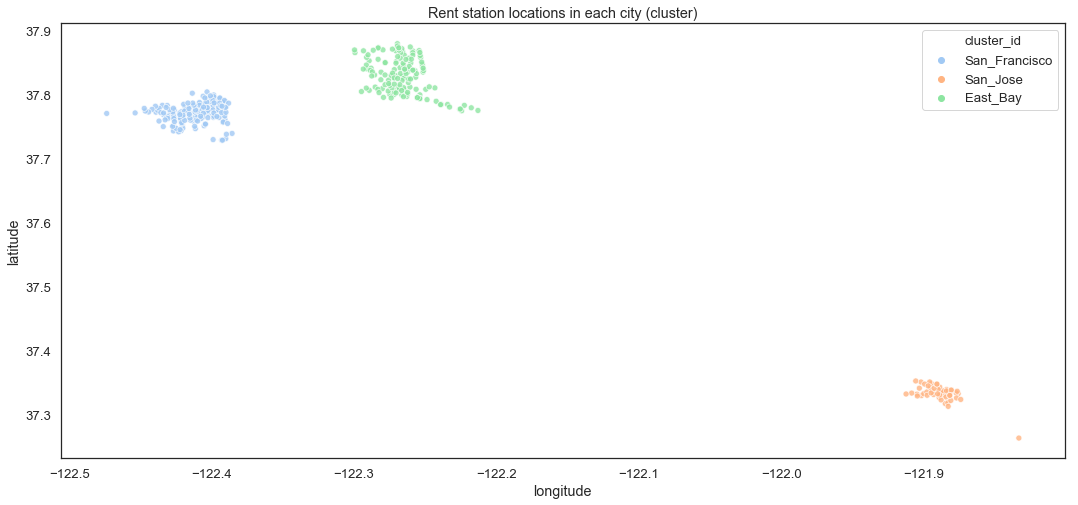

In [122]:
set_style()
sns.set_style("white")

fig, ax = fig, ax = plt.subplots()
fig.set_size_inches(18, 8)
ax = sns.scatterplot(x="longitude", y="latitude",
                      hue="cluster_id", alpha=.8,
                      data=clustered_stations);
#ax.set_ylim(rush_stations['latitude'].min(), rush_stations['latitude'].max())
ax.set_title("Rent station locations in each city (cluster)");

In [123]:
set_style()

Now we can see, that the cluster labels are within our station dataframe. Each cluster is colored differently and named by it's city's name.

In [124]:
clustered_stations['cluster_id'].value_counts()

San_Francisco    160
East_Bay         145
San_Jose          53
Name: cluster_id, dtype: int64

In [125]:
list(clustered_stations)

['latitude', 'longitude', 'cluster_id']

In [126]:
clustered_stations['cluster_id'].isnull().sum()

0

#### New feature: cluster id in rent table

Add the feature `cluster_id` into the **rent dataframe**. Therefor a sample of the rent dataframe is used. Otherwise iteration over all rows takes too much computation time (with 1863721 rows). A subset of size 10000 is used.

In [127]:
# prepare a sampled dataframe to reduce computation time
# therefore use only needed columns of cleaned rent and member dataframe
copy_of_member_and_rent = rent_clean.copy()
copy_of_member_and_rent['member_gender'] = member_clean['member_gender']
copy_of_member_and_rent['age'] = member_clean['age']
copy_of_member_and_rent['user_type'] = member_clean['user_type']

# sample from that df 10000 samples (randomly selection)
rent_sample = copy_of_member_and_rent.sample(10000)

In [128]:
# bring station id into temp clustered_stations dataframe
clustered_stations['id'] = -1

# iterate over all clustered stations to lookup the stations id in cleaned station df
for i, row in clustered_stations.iterrows():
    # lookup table - look up the cluster id of the given station id and write to rent table
    lat_temp = row['latitude']
    long_temp = row['longitude']
    frame = station_clean.query('latitude == @lat_temp')
    frame = station_clean.query('longitude == @long_temp')
    station_id = frame['id'].iloc[0]
    # write to short rent table
    clustered_stations.loc[i, 'id'] = station_id
    

In [129]:
# bring cluster id into rent_clean dataframe
rent_sample['cluster_id'] = -1

# iterate over rent df and lookup the cluster id in the clustered station df by using the sation id
for i, row in rent_sample.iterrows():
    # lookup table - look up the cluster id of the given station id and write to rent table
    station_id = row['start_station_id']
    frame = clustered_stations.query('id == @station_id')
    cluster_id = frame['cluster_id'].iloc[0]
    # write to short rent table
    rent_sample.loc[i, 'cluster_id'] = cluster_id

In [130]:
rent_sample['start_station_id'].nunique()

319

In [131]:
rent_sample['end_station_id'].nunique()

313

 321 of 358 stations are contained in the dataset. Thus, sample data the stations are still well enough distributed over all 3 cities.

Write amount also into stations dataframe.

In [132]:
# check if indexes are the same in station and clustered station df
(station_clean.index == clustered_stations.index).sum()

3

The ids from clustered_stations and station_clean are not the same. So we need to iterate through both using the station id to copy the cluster_ids to the station_clean dataframe. 

In [133]:
# because the indexes are not the same:
# we need to iterate over each row, to look up the cluster id to write it to the station df
station_clean['cluster_name'] = ''
for i, row in station_clean.iterrows():
    # lookup table - look up the cluster id of the given station id and write to rent table
    station_id = row['id']
    frame = clustered_stations.query('id == @station_id')
    cluster_id = frame['cluster_id'].iloc[0]
    # write to short rent table
    station_clean.loc[i, 'cluster_name'] = cluster_id

In [134]:
station_clean['cluster_name'].isnull().sum()

0

In [135]:
station_clean['cluster_name'].unique()

array(['San_Francisco', 'San_Jose', 'East_Bay'], dtype=object)

In [136]:
# copy the amount per station also into cleaned station dataframe
station_clean['amount'] = rush_stations['amount']
# and replace cluster ids with names
station_clean['cluster_id'] = station_clean['cluster_name'].replace({'San_Jose': 0, 'San_Francisco': 1, 'East_Bay': 2})

In [137]:
list(station_clean)

['id', 'latitude', 'longitude', 'name', 'cluster_id', 'cluster_name', 'amount']

Now let's have a look into the 3 different cities. Are their stations are all simialar busy or are their more busy stations or more busy cities?

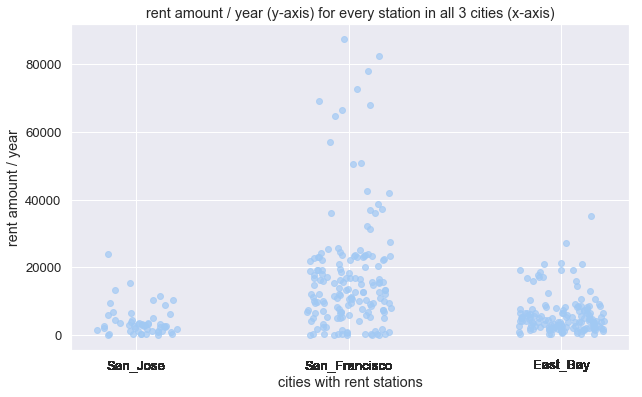

In [138]:
fig, ax = fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
sns.regplot( x = station_clean['cluster_id'], y = station_clean['amount'],
            x_jitter = 0.2, scatter_kws={"alpha":0.7}, fit_reg=False);
ax.set_xlabel('cities with rent stations')
ax.set_ylabel('rent amount / year')
ax.set_xticks(station_clean['cluster_id'])
ax.set_xticklabels(station_clean['cluster_name'])

ax.set_title('rent amount / year (y-axis) for every station in all 3 cities (x-axis)');

In the above plot we can see every station related to a cluster (city) and its rent amount / year (y-axis). We can see, that San Francisco has the most busiest stations. Now we want to create a new feature. A busy-feature, by splitting the y-axis values into 3 categories.

In [139]:
# new feature to distinguish between 3 busy stages
station_clean['busy'] = 0
# assign data two two groups of business (depending on amount)
where_above_upper_threshold = station_clean['amount'] > 60000 
where_underneith_upper_threshold = station_clean['amount'] <= 60000 
where_above_lower_threshold = station_clean['amount'] > 20000  
# add new features of busy stage by using the above filters (thresholds)
station_clean.loc[where_above_upper_threshold,'busy'] = 2
station_clean.loc[where_underneith_upper_threshold & where_above_lower_threshold,'busy'] = 1

list(station_clean)

['id',
 'latitude',
 'longitude',
 'name',
 'cluster_id',
 'cluster_name',
 'amount',
 'busy']

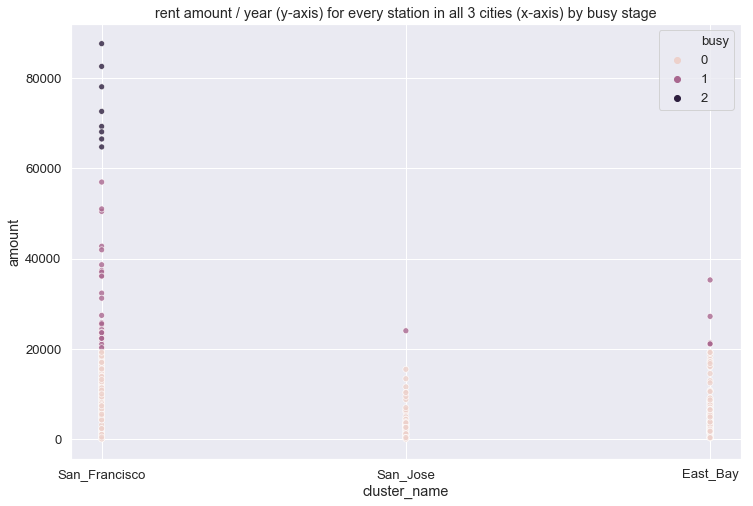

In [140]:
ax = sns.scatterplot(x="cluster_name", y="amount",x_jitter = True,
                      hue="busy", alpha=.8, 
                      data=station_clean)
ax.set_title("rent amount / year (y-axis) for every station in all 3 cities (x-axis) by busy stage");

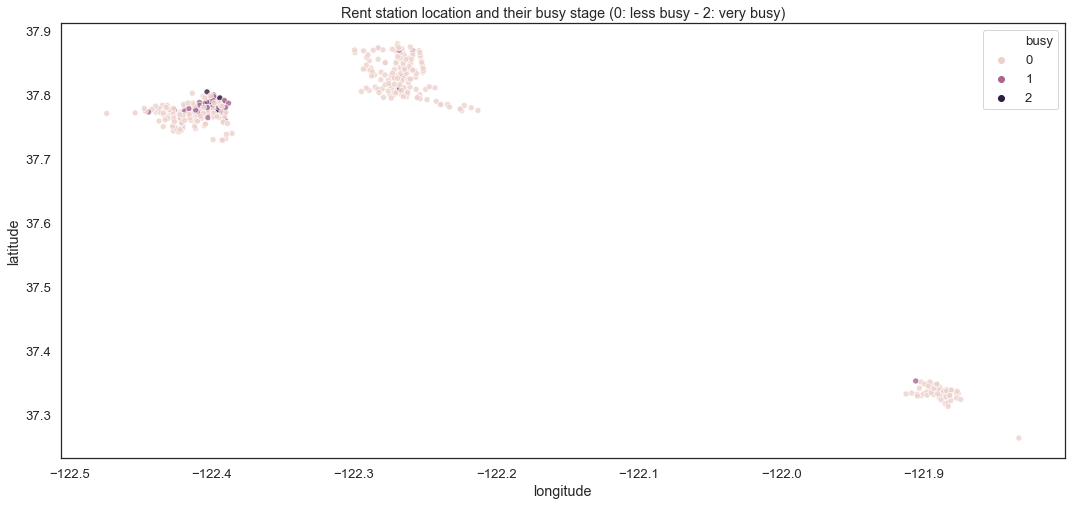

In [141]:
sns.set_style("white")

fig, ax = fig, ax = plt.subplots()
fig.set_size_inches(18, 8)
ax = sns.scatterplot(x="longitude", y="latitude",
                      hue="busy", alpha=.8,
                      data=station_clean);
#ax.set_ylim(rush_stations['latitude'].min(), rush_stations['latitude'].max())
ax.set_title("Rent station location and their busy stage (0: less busy - 2: very busy)");

Now we can see, the new `busy` categories, that are created as new features for further investigations.

Bring the new feature `busy` to the rent dataframe (using only the start rent staion id to combine for simplicity reasons).

In [142]:
# bring cluster id into rent_clean dataframe
rent_sample['busy'] = -1

for i, row in rent_sample.iterrows():
    # lookup table - look up the cluster id of the given station id and write to rent table
    station_id = row['start_station_id']
    frame = station_clean.query('id == @station_id')
    busy_value = frame['busy'].iloc[0]
    # write to short rent table
    rent_sample.loc[i, 'busy'] = busy_value

### 4.4 Member differences in different cities

In [143]:
rent_sample.groupby('cluster_id')['member_gender'].value_counts()

cluster_id     member_gender
East_Bay       Male             1379
               Female            641
               Other              46
San_Francisco  Male             5168
               Female           1594
               Other              84
San_Jose       Male              395
               Female            111
               Other               4
Name: member_gender, dtype: int64

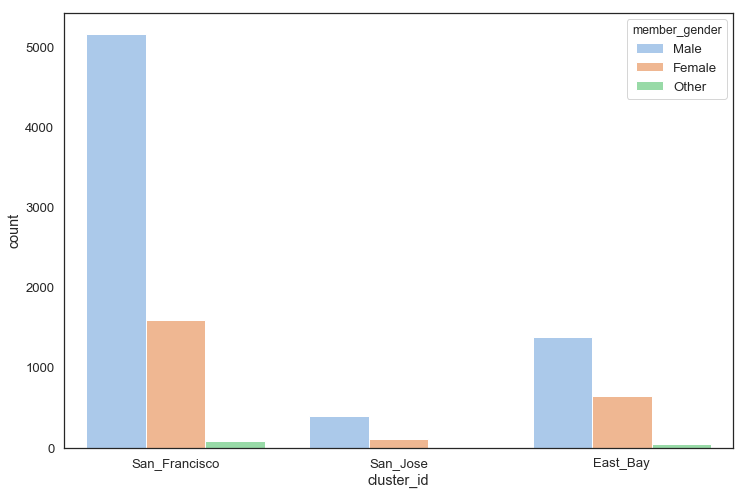

In [144]:
sns.countplot(data = rent_sample, x = 'cluster_id', hue = 'member_gender');
ax1.set_title("Amount of users in every city and per gender", y=1.02,fontsize=16);

In the above plot we can see the count of users (every rent counts as one individual user) per city (x-axis) and per gender (colors). In San Francisco only almmost 1/4 of the users are female and more than 3/4 are male. In East Bay almost 1/3 of the users are female and 2/3 are male. In San Jose a little bit more than 1/4 are female and less than 3/4 are male users.

In [145]:
rent_sample.groupby('member_gender')['age'].mean()

member_gender
Female    33.742955
Male      35.362116
Other     34.601504
Name: age, dtype: float64

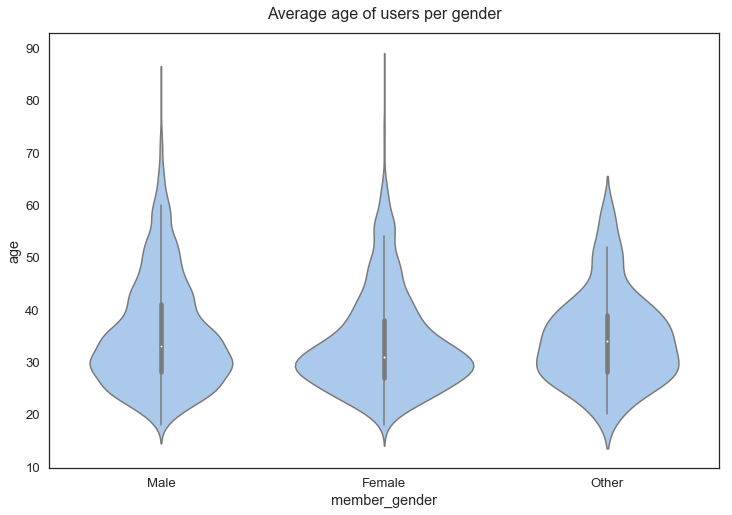

In [146]:
# left plot: violin plot
ax1 = sns.violinplot(data = rent_sample, x = 'member_gender', y = 'age', color = base_color)
ax1.set_title("Average age of users per gender", y=1.02,fontsize=16);

In the above plot we can see, that the average age of female users is 33.7 and of male users is 35.3 years old.

In [147]:
rent_sample.groupby('user_type')['age'].mean()

user_type
Customer      32.757246
Subscriber    35.239649
Name: age, dtype: float64

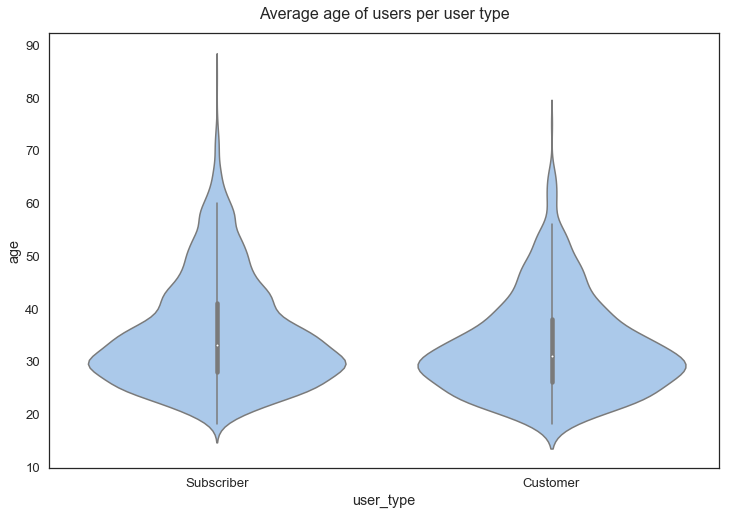

In [148]:
# left plot: violin plot
ax1 = sns.violinplot(data = rent_sample, x = 'user_type', y = 'age', color = base_color)
ax1.set_title("Average age of users per user type", y=1.02,fontsize=16);

In the above plot we can see, that the age of subscribers are more distributed than of customers (Maximum age is over 90 for subscriber and about 75 for customers). Also the average is younger for customer users with about 32 vs. 35 years for subsriber users.

In [149]:
rent_sample.groupby('cluster_id')['age'].mean()

cluster_id
East_Bay         34.308140
San_Francisco    35.504095
San_Jose         30.090196
Name: age, dtype: float64

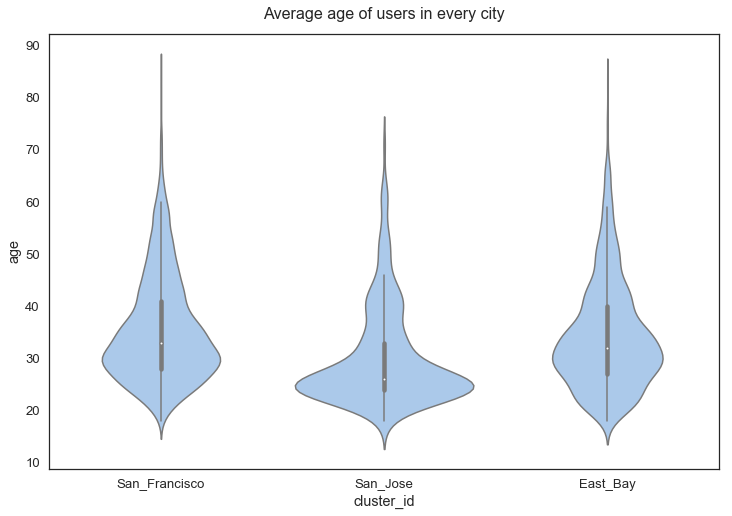

In [150]:
# left plot: violin plot
#plt.subplot(1, 2, 1)
ax1 = sns.violinplot(data = rent_sample, x = 'cluster_id', y = 'age', color = base_color)
ax1.set_title("Average age of users in every city", y=1.02,fontsize=16);

More interesting is the average age of the different cities. In San Francisco the user age's average is over 35, in East Bay about 34 and in San Jose the average age is 30 and less distributed over all ages.

In [151]:
rent_sample.groupby('cluster_id')['duration_sec'].mean()/60

cluster_id
East_Bay         12.045858
San_Francisco    15.362732
San_Jose         15.777052
Name: duration_sec, dtype: float64

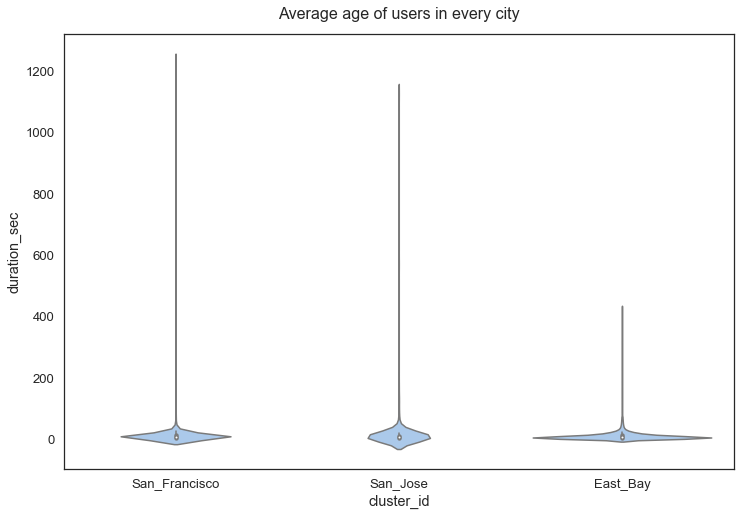

In [152]:
# left plot: violin plot
#plt.subplot(1, 2, 1)
ax1 = sns.violinplot(x = rent_sample['cluster_id'], y = rent_sample['duration_sec']/60, color = base_color)
ax1.set_title("Average age of users in every city", y=1.02,fontsize=16);

The average usage of the bike is in all cities approximatly the same: about 14-15minutes.

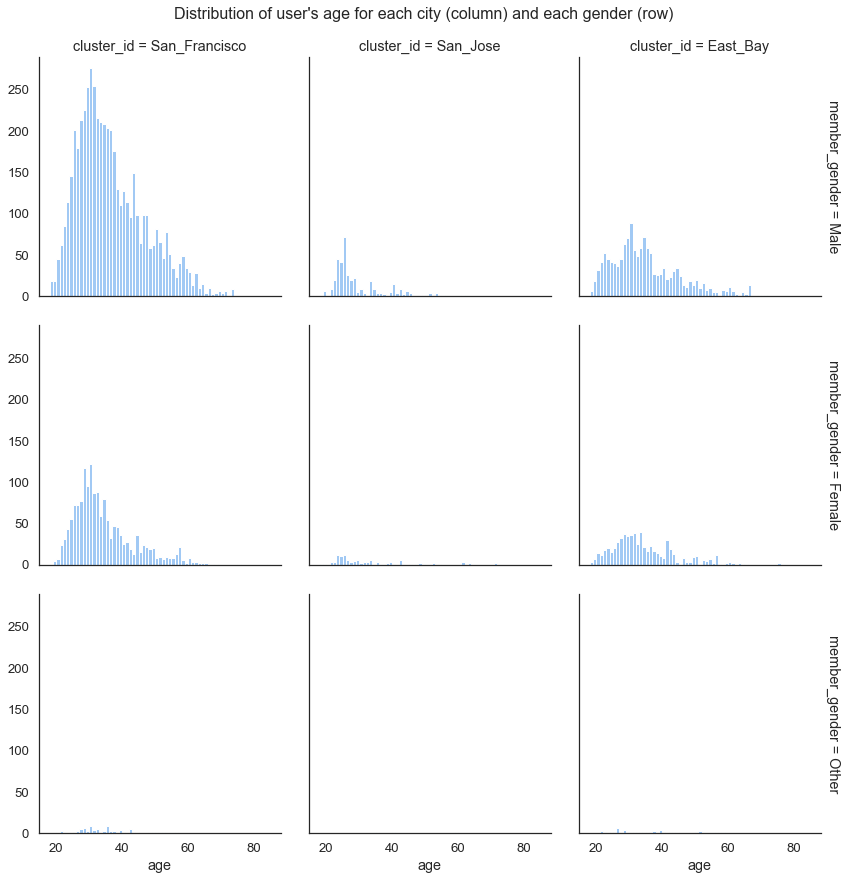

In [153]:
bins = np.arange(rent_sample['age'].min(), rent_sample['age'].max()+1, 1);

g = sns.FacetGrid(data = rent_sample, col = 'cluster_id', row = 'member_gender', height = 4,
                margin_titles = True);
g.map(plt.hist, 'age', bins = bins);
g.fig.suptitle("Distribution of user's age for each city (column) and each gender (row)", y=1.02,fontsize=16);

In this plot we can see the distribution of user's age for every gender (rows) in every city (columns). Beside that we can see that San Francisco has the most users and San Jose the fewest.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> The insights showed, that there are 3 cities, where the rent service is provided and where rent stations are located.

> Also, we could confirm that there are more busy rent stations and less busy rent stations. We categorized 3 different business levels to make further investigations on that. And plotted the locations with the amount of rents (businest factor). The busiest stations are located in San Francisco.

> With a clustering of the rent station locations, we could provide the city label for the station and rent data. With that label, we could investigate a analysis on user's age and gender in the different cities.

### Were there any interesting or surprising interactions between features?

> In San Francisco and San Jose only 1/5 of the users are female. Whereas in East Bay about 1/3 are female. So most users are male in every city.

> The average age of the users in San Jose is the lowest with 30 years. Whereas in East Bay and San Francisco the users are in average about 34 and 45 years old.

> The most users are allocated in San Francisco.